In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression as linreg
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import PolynomialFeatures as polyfeat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import factor_analyzer as fa
import pingouin as pg
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import gspread as gs
import gspread_dataframe as gd
import copy
import itertools


%matplotlib inline
plt.style.use('fivethirtyeight')

tss_df = pd.read_csv("data/combined_data.csv")
items_descr = pd.read_csv("data/description_items.csv")

tss_df.drop(columns="Unnamed: 0", inplace=True)

items_descr.set_index("Unnamed: 0", drop=True, inplace=True)
items_descr.index.set_names("item_label", inplace=True)
items_descr = pd.Series(items_descr.iloc[:, 0], name="item description")

tss_df.head(3)

,response_id,story_id,prompt_label,preset_label,sample,tss_coh_1,tss_coh_2,tss_coh_3,tss_coh_4,tss_coh_5,...,start,end,duration_in_sec,recorded,tss_order,qual_check_1,qual_check_1_order,qual_check_2,pass_qual_1,pass_qual_2
0,R_3LZPTbqxmeWvp7w,GEN_HF_6,High Fantasy,Genesis,Community,2.0,4.0,4.0,4.0,4.0,...,2022-02-17 07:41:22,2022-02-17 07:58:46,1044,2022-02-17 07:58:47,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN
1,R_3CCMkj9T7UgOtgP,ALL_HR_3,Historical Romance,All-Nighter,Community,2.0,4.0,2.0,1.0,2.0,...,2022-02-17 07:52:11,2022-02-17 08:01:19,548,2022-02-17 08:01:20,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN
2,R_3PBKFhmDXlAQNO6,ALL_HOR_2,Horror,All-Nighter,Community,5.0,5.0,1.0,1.0,3.0,...,2022-02-17 07:55:22,2022-02-17 08:03:16,473,2022-02-17 08:03:16,I had a hard time making sense of what was goi...,NaN,NaN,NaN,NaN,NaN


In [2]:
item_labels_li = [
    'tss_coh_1', 'tss_coh_2', 'tss_coh_3', 'tss_coh_4',
    'tss_coh_5', 'tss_coh_6', 'tss_coh_7', 'tss_coh_8', 'tss_coh_9',
    'tss_coh_10', 'tss_coh_11', 'tss_coh_12', 'tss_conch_1', 'tss_conch_2',
    'tss_conch_3', 'tss_conch_4', 'tss_conch_5', 'tss_conch_6',
    'tss_conch_7', 'tss_conch_8', 'tss_cre_1', 'tss_cre_2', 'tss_cre_3',
    'tss_cre_4', 'tss_cre_5', 'tss_cre_6', 'tss_cre_7', 'tss_cre_8',
    'tss_cre_9', 'tss_cre_10', 'tss_cre_11', 'tss_cre_12', 'tss_qua_1',
    'tss_qua_2', 'tss_qua_3', 'tss_qua_4', 'tss_qua_5', 'tss_qua_6',
    'tss_qua_7', 'tss_qua_8', 'tss_rep_1', 'tss_rep_2', 'tss_rep_3',
    'tss_rep_4', 'tss_rep_5', 'tss_rep_6', 'tss_rep_7', 'tss_rep_8',
    'tss_rep_9', 'tss_rep_10', 'tss_rep_11', 'tss_rep_12', 'tss_sty_1',
    'tss_sty_2', 'tss_sty_3', 'tss_sty_4', 'tss_sty_5', 'tss_sty_6',
    'tss_sty_7', 'tss_sty_8', 'tss_sty_9', 'tss_sty_10', 'tss_sty_11',
    'tss_sty_12', 'tss_pac_1', 'tss_pac_2', 'tss_pac_3', 'tss_pac_4',
    'tss_pac_5', 'tss_pac_6', 'tss_pac_7', 'tss_pac_8', 'tss_pac_9'
]

In [3]:
# Check missing data patterns
missing = tss_df[item_labels_li].isna()
print("Top 5 cols with missing data per col:")
print(missing.sum().sort_values(ascending=False).head(5))
print("\nTop 5 missing data per row:")
print(missing.sum(axis=1).sort_values(ascending=False).head(5))

# in this case it is straightforward - just drop the 3 rows with missing data
tss_df.dropna(subset=item_labels_li, inplace=True)

# if missing data should be more common with small amounts of missing data per case, might need different approach obv

Top 5 cols with missing data per col:
tss_pac_9     3
tss_qua_2     3
tss_rep_9     3
tss_coh_2     3
tss_cre_10    3
dtype: int64

Top 5 missing data per row:
117    72
137    65
77     35
168     0
156     0
dtype: int64


In [4]:
# check if items are appropriate for EFA
# correlations mostly |.3|-|.8|
items_corr = tss_df[item_labels_li].corr()

extreme_corrs_count_dict = {}
high_corr_li = []

# print out extreme corrs
total_report = ""
for index, row in items_corr.iterrows():
    variable1 = index
    corrs = row
    i = 0
    count = 0
    for variable2, corr in corrs.iteritems():
        if (variable1 != variable2) and ((abs(corr) < 0.3) or (abs(corr) > 0.8)):
            count += 1
            if abs(corr) > 0.8:
                high_corr_li.append((variable1, variable2, corr))
        i += 1
    extreme_corrs_count_dict[variable1] = count

extreme_corrs_count = pd.Series(extreme_corrs_count_dict)
print("Descriptives for extreme correlation count:")
print(extreme_corrs_count.describe())

# uhmm that are more extreme correlations as I would like
# but maybe subscales are fairly orthogonal?

Descriptives for extreme correlation count:
count    73.000000
mean     51.506849
std       9.972355
min      30.000000
25%      44.000000
50%      51.000000
75%      59.000000
max      69.000000
dtype: float64


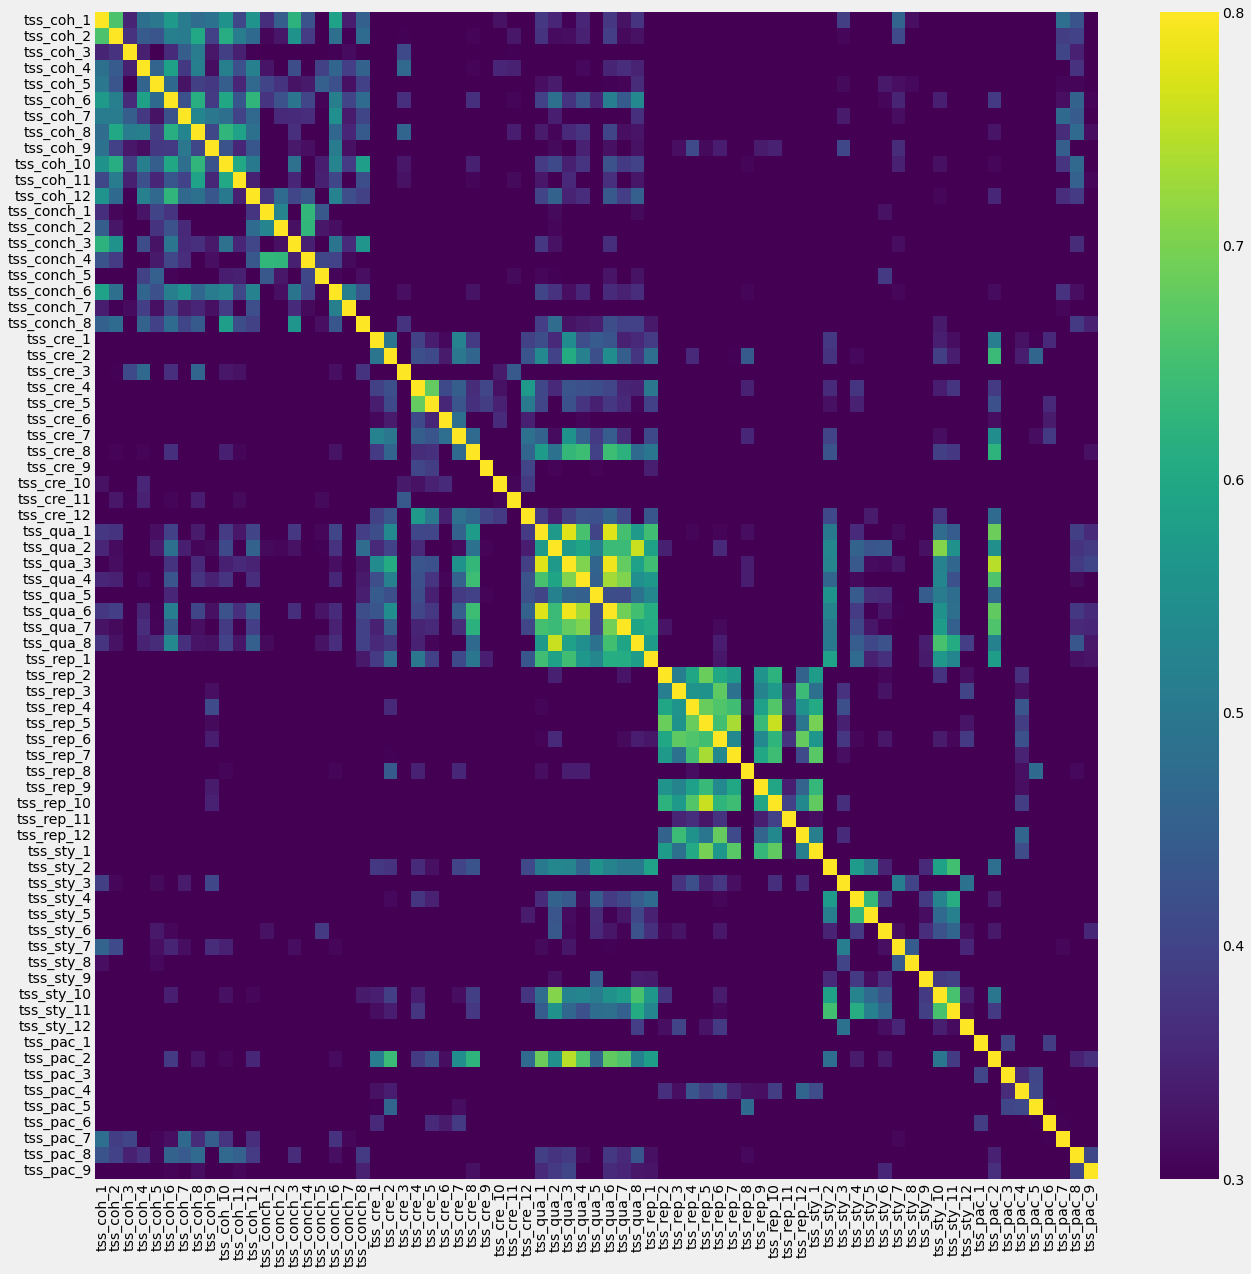

In [5]:
# Let us look at a heatmap (absolute values of correlations)
fig, ax = plt.subplots(figsize=(20, 20))

ax = sns.heatmap(abs(items_corr),
                 xticklabels=items_corr.columns.values,
                 yticklabels=items_corr.columns.values,
                 ax=ax, cmap="viridis", vmin=0.3, vmax=0.8)

# most item clusters are just surprising orthogonal (which is actually nice)

In [7]:
# Inspect suspicious items with low correlations here
susp_items = [
    "tss_cre_11",
    "tss_rep_8", "tss_rep_10",
    "tss_sty_8", "tss_sty_9", "tss_sty_12"
    "tss_pac_1", "tss_pac_3", "tss_pac_5", "tss_pac_6", "tss_pac_9"
]

for index, row in items_corr.iterrows():
    if index in susp_items:
        print("{}: {}".format(index, items_descr[index]))
        print("Correlations >= .3:")
        if row[(row >= .3) & (row.index != index)].empty:
            print("NONE - ALL correlations are < .3!")
        else:
            print(row[(row > .3) & (row.index != index)].to_string())
        print("")

tss_cre_11: The plot was typical for this kind of story.
Correlations >= .3:
tss_coh_3      0.303550
tss_coh_4      0.346377
tss_coh_6      0.306089
tss_coh_8      0.338729
tss_coh_11     0.313523
tss_conch_5    0.312559
tss_cre_3      0.436942

tss_rep_8: The plot had no development.
Correlations >= .3:
tss_conch_6    0.307195
tss_cre_2      0.439047
tss_rep_4      0.317120
tss_pac_4      0.321183
tss_pac_5      0.468883

tss_rep_10: Characters said or did the same thing many times over.
Correlations >= .3:
tss_coh_9     0.346045
tss_rep_3     0.570825
tss_rep_4     0.663403
tss_rep_5     0.757374
tss_rep_6     0.625467
tss_rep_7     0.644381
tss_rep_9     0.594121
tss_rep_11    0.395184
tss_rep_12    0.532603
tss_sty_1     0.677619
tss_sty_3     0.364997
tss_pac_4     0.388185

tss_sty_8: The writing style was too complicated to be understood easily.
Correlations >= .3:
tss_coh_1    0.318911
tss_sty_3    0.399659

tss_sty_9: The story contained a great deal of detail.
Correlations >=

In [8]:
# Consider excluding variables with lots correlations < .3
items_analysis_li = copy.deepcopy(item_labels_li)

# excluded_items_li = [
#     "tss_sty_8"
# ]

# for item in excluded_items_li:
#     items_analysis_li.remove(item)

In [9]:
# Check for multicollinearity
def reduce_multicoll(df, vars_li, vars_descr=[], print_details=True):
    reduced_vars = copy.deepcopy(vars_li)
    print("Beginning check for multicollinearity")
    vars_corr = df[reduced_vars].corr()
    det = np.linalg.det(vars_corr)
    print("\nDeterminant of initial correlation matrix: {}\n".format(det))

    if det > .00001:
        print("Determinant is > .00001. No issues with multicollinearity detected.")
        return(reduced_vars)

    print("Starting to remove redundant variables by acessing mutlicollinearity with VIF...\n")
    count_missing = len(df) - len(df.dropna(subset=vars_li))
    if count_missing > 0:
        print("This requries dropping missing values.",
              "The following procedure will ignore {} cases with missing values".format(count_missing))
    while det <= .00001:
        # could implement pairwise dropping of missing here at some point
        # but until you have a case with lots of missing data, this will work fine
        x_df = df.dropna(subset=vars_li)[reduced_vars]
        vifs = [vif(x_df.values, i)
                for i in range(len(x_df.columns))]
        vif_data = pd.Series(vifs, index=x_df.columns)
        vif_max = (vif_data.idxmax(), vif_data.max())

        if print_details:
            print("Excluded item {}. VIF: {:.2f}".format(
                vif_max[0], vif_max[1]))

            if len(vars_descr) > 0:
                print("('{}')".format(vars_descr[vif_max[0]]))
            print("")

        reduced_vars.remove(vif_max[0])

        vars_corr = df[reduced_vars].corr()
        det = np.linalg.det(vars_corr)

    print("Done! Determinant is now: {:.6f}".format(det))
    count_removed = len(vars_li) - len(reduced_vars)
    print("I have excluded {} redunant items with {} items remaining".format(
        count_removed, len(reduced_vars)))

    return(reduced_vars)

In [10]:
items_analysis_li = reduce_multicoll(
    tss_df, items_analysis_li, vars_descr=items_descr, print_details=True)

Beginning check for multicollinearity

Determinant of initial correlation matrix: 1.3432894630507003e-24

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item tss_qua_3. VIF: 49.57
('The story was fun to read.')

Excluded item tss_coh_1. VIF: 34.82
('I had a hard time making sense of what was going on in the story.')

Excluded item tss_coh_12. VIF: 34.24
('The story lacked logic.')

Excluded item tss_cre_5. VIF: 31.07
('The story was imaginative.')

Excluded item tss_qua_6. VIF: 30.77
('I liked this story.')

Excluded item tss_cre_2. VIF: 27.01
('The story was boring.')

Excluded item tss_rep_4. VIF: 26.87
('The story was very repetitive.')

Excluded item tss_conch_5. VIF: 26.61
('The descriptions of characters in the story were plausible.')

Excluded item tss_rep_5. VIF: 25.79
('In the story, the same things happened again and again.')

Excluded item tss_conch_3. VIF: 25.12
('My understanding of the characters in the story is unclear.')

Excl

In [11]:
# Check Sampling Adequacy (KMO)
# (if SVD does not converge, dropna for participants with too many missing items)
# (might need to experiment how many missing are still okay)

tss_df.dropna(subset=items_analysis_li, thresh=1, inplace=True)

kmo = fa.factor_analyzer.calculate_kmo(tss_df[items_analysis_li])

print("Overall KMO: {}".format(kmo[1]))

i = 0
low_item_kmo = False
for item_kmo in kmo[0]:
    if item_kmo < .6:
        low_item_kmo = True
        item_label = item_labels_li[i]
        print("Low KMO for {} ('{}'): {}".format(
            item_label, items_descr[item_label], item_kmo))
    i += 1

if low_item_kmo == False:
    print("All item KMOs are >.6")

# Guidelines for KMO (Kaiser & Rice, 1974)
# Marvellous: values in the 0.90s
# Meritorious: values in the 0.80s
# Middling: values in the 0.70s
# Mediocre: values in the 0.60s
# Unacceptable: values in the 0.50s

Overall KMO: 0.8417417475643759
All item KMOs are >.6


In [12]:
# Determine number of factors
# Use Screeplot & Parallel Analysis

# Function to output results for parallel parallel analysis
def parallel_analysis(df, vars_li, k=100, facs_to_display=15, print_graph=True, print_table=True):
    # EFA with no rotation to get EVs
    efa = fa.factor_analyzer.FactorAnalyzer(rotation=None)

    # EVs for actual data
    efa.fit(df[vars_li])
    ev_pca, ev_efa = efa.get_eigenvalues()

    # Prepare random data for parallel analysis
    n, m = df[vars_li].shape
    par_efa = fa.factor_analyzer.FactorAnalyzer(rotation=None)

    # Create df to store the values
    ev_par_df = pd.DataFrame(columns=range(1, m+1))

    # Run the fit 'k' times over a random matrix
    for runNum in range(0, k):
        par_efa.fit(np.random.normal(size=(n, m)))
        cur_ev_ser = pd.Series(par_efa.get_eigenvalues()[
                               1], index=ev_par_df.columns)
        ev_par_df = ev_par_df.append(cur_ev_ser, ignore_index=True)
    # get 95th percentile for the evs
    par_95per = ev_par_df.quantile(0.95)

    if print_graph:
        # Draw graph
        plt.figure(figsize=(10, 6))

        # Line for eigenvalue 1
        plt.plot([1, facs_to_display+1], [1, 1], 'k--', alpha=0.3)
        # For the random data (parallel analysis)
        plt.plot(range(1, len(par_95per[:facs_to_display])+1),
                 par_95per[:facs_to_display], 'b', label='EVs - random', alpha=0.4)
        # Markers and line for actual EFA eigenvalues
        plt.scatter(
            range(1, len(ev_efa[:facs_to_display])+1), ev_efa[:facs_to_display])
        plt.plot(range(1, len(ev_efa[:facs_to_display])+1),
                 ev_efa[:facs_to_display], label='EVs - survey data')

        plt.title('Parallel Analysis Scree Plots', {'fontsize': 20})
        plt.xlabel('Components', {'fontsize': 15})
        plt.xticks(ticks=range(1, facs_to_display+1),
                   labels=range(1, facs_to_display+1))
        plt.ylabel('Eigenvalue', {'fontsize': 15})
        plt.legend()
        plt.show()

    if print_table:
        # Create simple table with values for 95th percentile for random data and EVs for actual data
        print("Factor eigenvalues for the 95th percentile of {} random matricesand for survey data for first {} factors:\n".
              format(k, facs_to_display))
        print("\033[1mFactor\tEV - random data 95h perc.\tEV survey data\033[0m")

        last_index = 0
        last_95per_par = 0
        last_ev_efa = 0
        found_threshold = False

        # Loop that prints previous (!) values
        # if current EV from survey data is smaller than 95th percentile from random data, we reached the threshold
        # in that case print the previous values in bold as it marks the number of factors determined by parallel analysis
        for index, cur_ev_par in par_95per[:facs_to_display].iteritems():
            cur_ev_efa = ev_efa[index-1]
            if (index > 1) & (cur_ev_par >= cur_ev_efa) & (found_threshold == False):
                found_threshold = True
                print("\033[1m{}\t{:.2f}\t\t\t\t{:.2f}\033[0m".format(
                    last_index, last_95per_par, last_ev_efa))
            elif (index > 1):
                print("{}\t{:.2f}\t\t\t\t{:.2f}".format(
                    last_index, last_95per_par, last_ev_efa))

            if index == len(par_95per[:facs_to_display]):
                print("{}\t{:.2f}\t\t\t\t{:.2f}".format(
                    index, cur_ev_par, cur_ev_efa))

            last_index = index
            last_95per_par = cur_ev_par
            last_ev_efa = cur_ev_efa

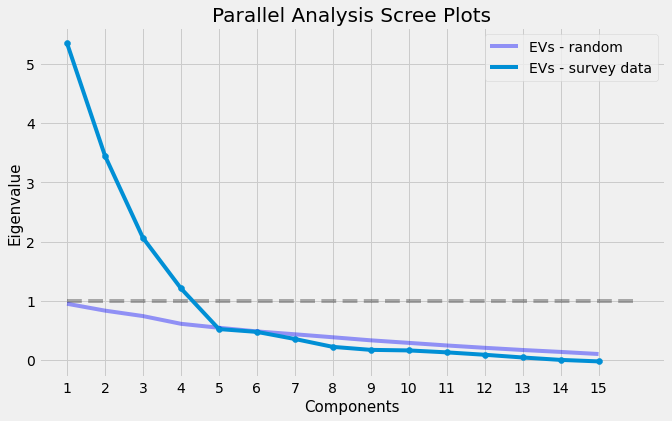

Factor eigenvalues for the 95th percentile of 100 random matricesand for survey data for first 15 factors:

Factor	EV - random data 95h perc.	EV survey data
1	0.95				5.35
2	0.83				3.45
3	0.74				2.06
4	0.61				1.21
5	0.54				0.52
6	0.48				0.47
7	0.43				0.36
8	0.38				0.22
9	0.33				0.17
10	0.29				0.16
11	0.25				0.13
12	0.21				0.09
13	0.17				0.04
14	0.14				0.00
15	0.10				-0.02


In [13]:
parallel_analysis(tss_df, items_analysis_li)

# determine factors to investigate based on screeplot and parallel analysis
# if both methods yield different results, examine both number of factors
# (decide for one based on whether you get a clean solution and on how interpretable the solution is)

In [14]:
# Decide on rotation (orthogonal: Varimax, oblique: Oblimin)

# Run oblique rotation
efa = fa.FactorAnalyzer(n_factors=4, rotation='oblimin')
efa.fit(tss_df[items_analysis_li])
# Display factor correlation matrix
print("\nFactor Correlation Matrix (Oblique Rotation):")
print(efa.phi_)
# If matrix has clear correlations between factors, than this indicates the need for an oblique rotation
# if in doubt use oblique


Factor Correlation Matrix (Oblique Rotation):
[[ 1.          0.08343833 -0.27438602  0.13915139]
 [ 0.08343833  1.          0.10841532 -0.22090834]
 [-0.27438602  0.10841532  1.         -0.07738202]
 [ 0.13915139 -0.22090834 -0.07738202  1.        ]]


In [15]:
def iterative_efa(data, vars_analsis, n_facs=4, rotation_method="Oblimin",
                  comm_thresh=0.2, main_thresh=0.4, cross_thres=0.3, load_diff_thresh=0.2,
                  print_details=False, print_par_plot=False, print_par_table=False,
                  par_k=100, par_n_facs=15):
    efa = fa.FactorAnalyzer(n_factors=n_facs, rotation=rotation_method)

    final_solution = False

    curr_vars = copy.deepcopy(vars_analsis)

    i = 1
    while final_solution == False:
        # Fit EFA
        efa.fit(data[curr_vars])
        print("Fitted solution #{}\n".format(i))

        # print screeplot and/or table for parallel analysis if option was chosen
        # but not for first run (assuming it was already checked to select number of factors)
        if (i > 1) and print_par_plot or print_par_table:
            parallel_analysis(data, curr_vars, k=par_k, facs_to_display=par_n_facs,
                              print_graph=print_par_plot, print_table=print_par_table)

        # Check 1: Check communcalities
        print("Checking for low communalities")
        comms = pd.DataFrame(efa.get_communalities(
        ), index=tss_df[curr_vars].columns, columns=['Communality'])
        mask_low_comms = comms["Communality"] < comm_thresh

        if comms[mask_low_comms].empty:
            print("All communalities above {}\n".format(comm_thresh))
        else:
            # save bad items and remove them
            bad_items = comms[mask_low_comms].index
            print("Detected {} items with low communality. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nCommunality: {:.4f}\n".format(
                        item, items_descr[item], comms.loc[item, "Communality"]))
                curr_vars.remove(item)
            i += 1
            continue

        # Check 2: Check for low main loading
        print("Checking for low main loading")
        loadings = pd.DataFrame(efa.loadings_, index=data[curr_vars].columns)
        max_loadings = abs(loadings).max(axis=1)
        mask_low_main = max_loadings < main_thresh
        if max_loadings[mask_low_main].empty:
            print("All main loadings above {}\n".format(main_thresh))
        else:
            # save bad items and remove them
            bad_items = max_loadings[mask_low_main].index
            print("Detected {} items with low main loading. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nMain (absolute) Loading: {:.4f}\n".format(
                        item, items_descr[item], abs(loadings.loc[item]).max()))
                curr_vars.remove(item)
            i += 1
            continue

        # check 3: Check for high cross loadings
        print("Checking high cross loadings")

        # create df that stores main_load, largest crossload and difference between the two
        crossloads_df = pd.DataFrame(index=curr_vars)

        crossloads_df["main_load"] = abs(loadings).max(axis=1)
        crossloads_df["cross_load"] = abs(loadings).apply(
            lambda row: row.nlargest(2).values[-1], axis=1)
        crossloads_df["diff"] = crossloads_df["main_load"] - \
            crossloads_df["cross_load"]

        mask_high_cross = (crossloads_df["cross_load"] > cross_thres) | (
            crossloads_df["diff"] < load_diff_thresh)

        if crossloads_df[mask_high_cross].empty:
            print("All cross_loadins loadings below {}".format(cross_thres),
                  "and differences between main loading and crossloadings above {}.\n".format(load_diff_thresh))
        else:
            # save bad items and remove them
            bad_items = crossloads_df[mask_high_cross].index
            print("Detected {} items with high cross loading. Excluding them for next analysis.\n".format(
                len(bad_items)))
            for item in bad_items:
                if print_details:
                    print("Removed item {}: {}\nLoadings: \n{}\n".format(
                        item, items_descr[item], loadings.loc[item]))
                curr_vars.remove(item)
            i += 1
            continue

        print("Final solution reached.")
        final_solution = True

        corrs = data[curr_vars].corr()
        det = np.linalg.det(corrs)
        print("\nDeterminant of correlation matrix: {}".format(det))
        if det > 0.00001:
            print("Determinant looks good!")
        else:
            print("Determinant is smaller than 0.00001!")
            print(
                "Consider using stricer criteria and/or removing highly correlated vars")

        kmo = fa.factor_analyzer.calculate_kmo(data[curr_vars])
        print("Overall KMO: {}".format(kmo[1]))

        i = 0
        low_item_kmo = False
        for item_kmo in kmo[0]:
            if item_kmo < .6:
                low_item_kmo = True
                item_label = curr_vars[i]
                print("Low KMO for {} ('{}'): {}".format(
                    item_label, items_descr[item_label], item_kmo))
            i += 1
        if low_item_kmo == False:
            print("All item KMOs are >.6")

# Determinant should be > .00001

    return(efa, curr_vars)

# print relevant loadings for each factor to output


def print_sorted_loadings(efa, item_lables, load_thresh=0.4, descr=[]):
    loadings = pd.DataFrame(efa.loadings_, index=item_lables)
    n_load = loadings.shape[1]

    if len(descr) > 0:
        loadings["descr"] = loadings.apply(lambda x: descr[x.name], axis=1)

    for i in range(0, n_load):
        mask_relev_loads = abs(loadings[i]) > load_thresh
        sorted_loads = loadings[mask_relev_loads].sort_values(
            i, key=abs, ascending=False)
        print("Relevant loadings for factor {}".format(i))
        if len(descr) > 0:
            print(sorted_loads[[i, "descr"]].to_string(), "\n")
        else:
            print(sorted_loads[i].to_string(), "\n")


def rev_items_and_return(df, efa, item_lables, load_thresh=0.4, min_score=1, max_score=5):

    loadings = pd.DataFrame(efa.loadings_, index=item_lables)
    n_load = loadings.shape[1]

    items_per_fact_dict = {}

    # loop through n factors
    # determine relevant items that are positive (can just be used as is)
    # and items with negative loads (need to be refersed)
    for i in range(0, n_load):
        mask_pos_loads = loadings[i] > load_thresh
        mask_neg_loads = loadings[i] < -load_thresh
        pos_items = loadings[mask_pos_loads].index.tolist()
        neg_items = loadings[mask_neg_loads].index.tolist()

        # add items with positive items directly to dict
        items_per_fact_dict[i] = pos_items

        # create reverse-coded item in df for items with negative loadings
        for item in neg_items:
            rev_item_name = item + "_rev"
            df[rev_item_name] = (df[item] - (max_score+min_score)) * -1
            items_per_fact_dict[i].append(rev_item_name)

    return items_per_fact_dict

Fitted solution #1

Checking for low communalities
Detected 1 items with low communality. Excluding them for next analysis.

Removed item tss_conch_4: The way the characters were described was inconsistent.
Communality: 0.1994

Fitted solution #2



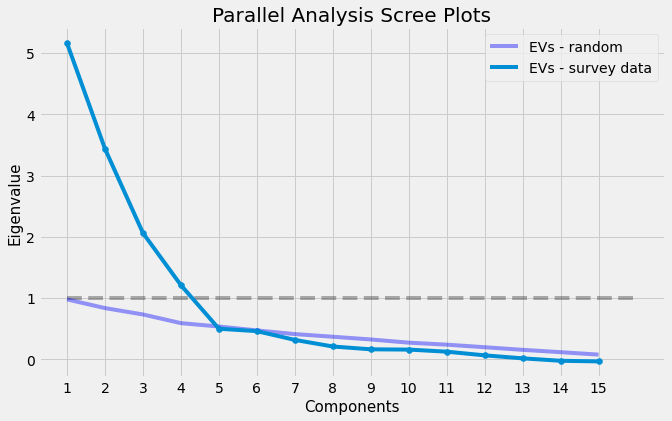

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 2 items with low main loading. Excluding them for next analysis.

Removed item tss_sty_8: The writing style was too complicated to be understood easily.
Main (absolute) Loading: 0.3442

Removed item tss_pac_9: There's nothing superfluous or unnecessary in this story.
Main (absolute) Loading: 0.3795

Fitted solution #3



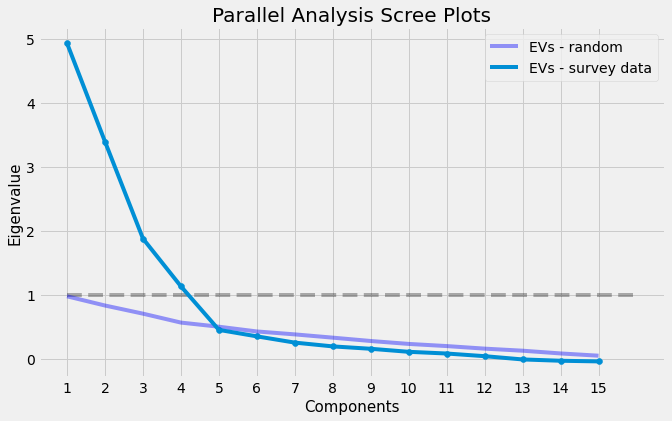

Checking for low communalities
All communalities above 0.2

Checking for low main loading
Detected 1 items with low main loading. Excluding them for next analysis.

Removed item tss_cre_6: It was surprising how things turned out in the story.
Main (absolute) Loading: 0.3976

Fitted solution #4



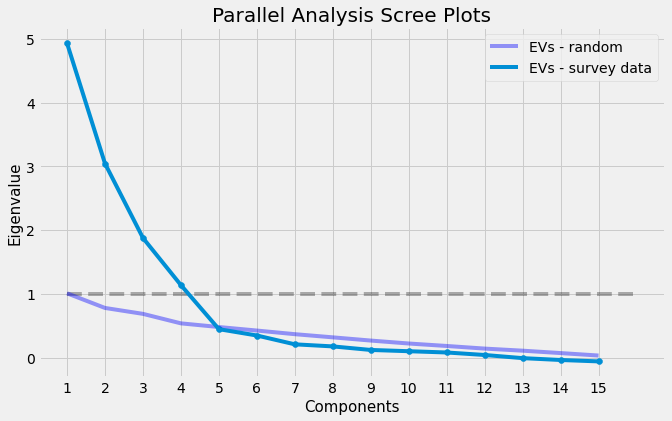

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 5 items with high cross loading. Excluding them for next analysis.

Removed item tss_coh_9: The story felt like a series of disconnected sentences.
Loadings: 
0   -0.511404
1   -0.010508
2    0.480602
3    0.081151
Name: tss_coh_9, dtype: float64

Removed item tss_cre_7: There were interesting twists and turns in the story.
Loadings: 
0   -0.000729
1    0.555949
2    0.060856
3   -0.426039
Name: tss_cre_7, dtype: float64

Removed item tss_qua_7: I would like to read more stories like this one.
Loadings: 
0    0.362286
1    0.599314
2   -0.179200
3   -0.059553
Name: tss_qua_7, dtype: float64

Removed item tss_rep_2: This story avoided repetition.
Loadings: 
0    0.056766
1    0.319201
2   -0.612972
3   -0.042813
Name: tss_rep_2, dtype: float64

Removed item tss_pac_6: There was plenty of action in the story.
Loadings: 
0   -0.179668

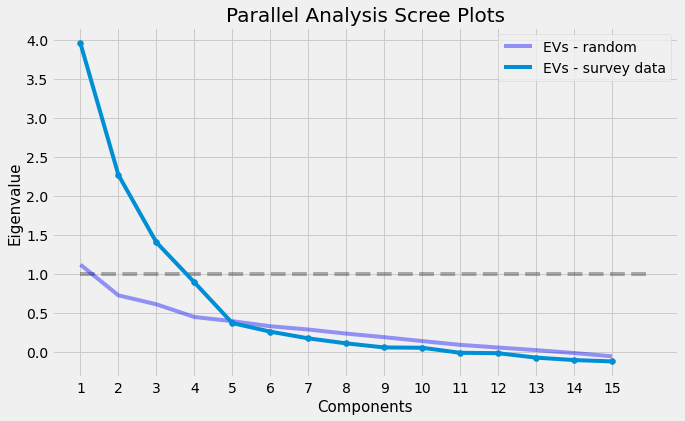

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3 and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.0017599327501124583
Determinant looks good!
Overall KMO: 0.8065276591328461
All item KMOs are >.6


In [16]:
four_facs = iterative_efa(tss_df, items_analysis_li, n_facs=4, rotation_method="Varimax", print_details=True,
                          print_par_plot=True)

In [17]:
efa_4 = four_facs[0]
items_4 = four_facs[1]

print_sorted_loadings(efa_4, items_4, load_thresh=0.32, descr=items_descr)

Relevant loadings for factor 0
                    0                                                                     descr
tss_coh_4    0.693520                                      The plot of the story was plausible.
tss_coh_6    0.683754                                     The story felt like a coherent story.
tss_coh_11   0.633446                                              The story had a clear theme.
tss_pac_8    0.593913                      All elements of the story were relevant to the plot.
tss_coh_3    0.585499                                   The story appeared to be a single plot.
tss_conch_8  0.583763  It was easy to understand the motivation of the characters in the story.
tss_cre_3    0.580944                        The plot development in the story was predictable.
tss_pac_7   -0.500974                  Many things seemed to be happening at once in the story.
tss_conch_7 -0.450273                     How characters in the story acted seemed implausible. 

Relevan

In [18]:
items_per_fac_4 = rev_items_and_return(tss_df, efa_4, items_4)

for factor_n in items_per_fac_4:
    print("Internal consistency for factor {}:".format(factor_n))

    items = items_per_fac_4[factor_n]

    if len(items) > 2:
        cron_alpha = pg.cronbach_alpha(data=tss_df[items], ci=.95)
        print("Cronbachs alpha = {:.4f}, 95% CI = [{:.2f}, {:.2f}]".format(
            cron_alpha[0], cron_alpha[1][0], cron_alpha[1][1]))

        # loop over items for current factor
        # compute cronbach's alpha by excluding one item at a time
        print("\nCronbach's alpha when excluding variable...")
        for cur_item in items:
            # create list with all items except current item
            items_wo_cur_item = copy.deepcopy(items)
            items_wo_cur_item.remove(cur_item)

            cur_cron_alpha = pg.cronbach_alpha(
                data=tss_df[items_wo_cur_item], ci=.95)[0]

            # bold entry if excluding item leads to improvement
            bold_or_not = "\033[1m" if cur_cron_alpha > cron_alpha[0] else "\033[0m"
            print("{}{}: {:.4f}\033[0m".format
                  (bold_or_not, cur_item, cur_cron_alpha))

        print("\n")

# consider dropping items at this point
# Consider dropping alpha if it would noticeable improve internal consistency
# Drop items if you have > 6 items and dropping rest would not noticeable decrease internal consistency
# (also take loadings into account here)
# Be wary of dropping items if it would bring you down to 2 items...

Internal consistency for factor 0:
Cronbachs alpha = 0.8310, 95% CI = [0.80, 0.86]

Cronbach's alpha when excluding variable...
tss_coh_3: 0.8162
tss_coh_4: 0.8015
tss_coh_6: 0.7994
tss_coh_11: 0.8110
tss_conch_8: 0.8129
tss_cre_3: 0.8173
tss_pac_8: 0.8165
tss_conch_7_rev: 0.8239
tss_pac_7_rev: 0.8232


Internal consistency for factor 1:
Cronbachs alpha = 0.7093, 95% CI = [0.65, 0.76]

Cronbach's alpha when excluding variable...
tss_cre_9: 0.6903
tss_cre_12: 0.6509
tss_sty_5: 0.6560
tss_sty_9: 0.6752
tss_sty_10: 0.6309


Internal consistency for factor 2:
Cronbachs alpha = 0.6902, 95% CI = [0.62, 0.75]

Cronbach's alpha when excluding variable...
tss_rep_3: 0.5611
tss_rep_9: 0.5975
tss_rep_11: 0.6604
tss_sty_3: 0.6728


Internal consistency for factor 3:
Cronbachs alpha = 0.6732, 95% CI = [0.60, 0.74]

Cronbach's alpha when excluding variable...
tss_rep_8: 0.6333
tss_pac_3: 0.5758
tss_pac_5: 0.5557
tss_pac_1_rev: 0.6549




In [19]:
items_4_2 = copy.deepcopy(items_4)
# items_4_2.remove("tss_rep_11")
items_4_2.extend(["tss_rep_4", "tss_rep_5",
                  "tss_rep_6", "tss_rep_7", "tss_rep_10", "tss_rep_12"])
items_4_2.extend(["tss_cre_1", "tss_cre_2", "tss_cre_4",
                  "tss_cre_5", "tss_cre_10", "tss_cre_11"])
items_4_2.extend(["tss_pac_2", "tss_pac_4"])
items_4_2.extend(["tss_sty_1", "tss_sty_2", "tss_sty_4", "tss_sty_11"])

In [20]:
items_4_2 = reduce_multicoll(
    tss_df, items_4_2, vars_descr=items_descr, print_details=True)

Beginning check for multicollinearity

Determinant of initial correlation matrix: 4.3032405572353027e-10

Starting to remove redundant variables by acessing mutlicollinearity with VIF...

Excluded item tss_cre_5. VIF: 25.04
('The story was imaginative.')

Excluded item tss_rep_5. VIF: 21.82
('In the story, the same things happened again and again.')

Excluded item tss_rep_4. VIF: 20.26
('The story was very repetitive.')

Excluded item tss_sty_4. VIF: 19.72
('The text contained a broad vocabulary.')

Excluded item tss_rep_12. VIF: 19.30
('Particular words were used too often in the story.')

Excluded item tss_sty_11. VIF: 18.96
('The author's choice of words was elegant')

Excluded item tss_cre_2. VIF: 18.87
('The story was boring.')

Excluded item tss_sty_1. VIF: 17.40
('There were similar events that occurred repeatedly in the story.')

Excluded item tss_cre_4. VIF: 16.58
('The story was creative.')

Excluded item tss_sty_2. VIF: 16.45
('This story used interesting language.')

Exclud

Fitted solution #1

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 6 items with high cross loading. Excluding them for next analysis.

Removed item tss_coh_6: The story felt like a coherent story.
Loadings: 
0    0.663198
1   -0.147582
2    0.332713
3    0.086064
Name: tss_coh_6, dtype: float64

Removed item tss_sty_3: The story had sentences that were unreadable
Loadings: 
0   -0.257532
1    0.416512
2   -0.007263
3    0.214526
Name: tss_sty_3, dtype: float64

Removed item tss_cre_1: The story felt dynamic.
Loadings: 
0   -0.042689
1   -0.101102
2    0.528689
3   -0.390676
Name: tss_cre_1, dtype: float64

Removed item tss_cre_10: The story was unconventional.
Loadings: 
0   -0.469413
1    0.088120
2    0.308355
3   -0.071137
Name: tss_cre_10, dtype: float64

Removed item tss_pac_2: The story was exciting to read.
Loadings: 
0    0.234161
1   -0.081555
2    0.622446
3   -0.3001

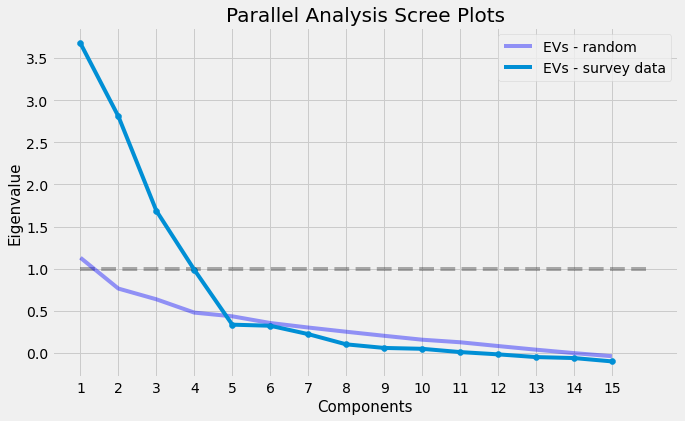

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
Detected 1 items with high cross loading. Excluding them for next analysis.

Removed item tss_conch_8: It was easy to understand the motivation of the characters in the story.
Loadings: 
0    0.566016
1   -0.047369
2    0.303779
3   -0.019157
Name: tss_conch_8, dtype: float64

Fitted solution #3



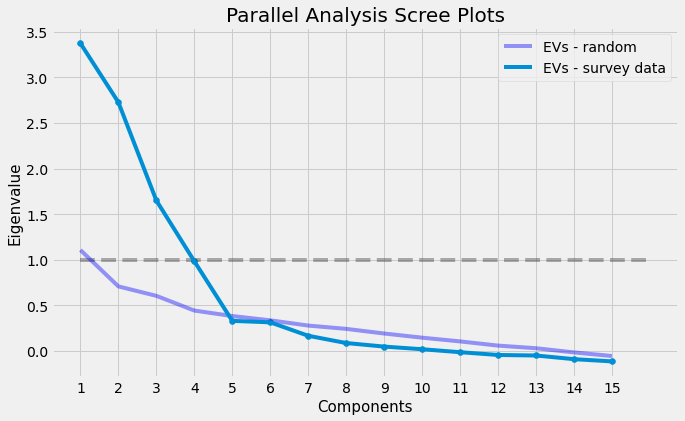

Checking for low communalities
All communalities above 0.2

Checking for low main loading
All main loadings above 0.4

Checking high cross loadings
All cross_loadins loadings below 0.3 and differences between main loading and crossloadings above 0.2.

Final solution reached.

Determinant of correlation matrix: 0.0014777425214446416
Determinant looks good!
Overall KMO: 0.795870490153211
All item KMOs are >.6


In [21]:
four_facs_2 = iterative_efa(tss_df, items_4_2, n_facs=4, rotation_method="Varimax", print_details=True,
                            print_par_plot=True)

In [22]:
efa_4_2 = four_facs_2[0]
items_4_2 = four_facs_2[1]

print_sorted_loadings(efa_4_2, items_4_2, load_thresh=0.4, descr=items_descr)

Relevant loadings for factor 0
                    0                                                     descr
tss_coh_4    0.654645                      The plot of the story was plausible.
tss_coh_3    0.613992                   The story appeared to be a single plot.
tss_coh_11   0.613702                              The story had a clear theme.
tss_cre_3    0.612144        The plot development in the story was predictable.
tss_pac_8    0.578000      All elements of the story were relevant to the plot.
tss_cre_11   0.530484              The plot was typical for this kind of story.
tss_pac_7   -0.507829  Many things seemed to be happening at once in the story.
tss_conch_7 -0.436678     How characters in the story acted seemed implausible. 

Relevant loadings for factor 1
                   1                                                                             descr
tss_rep_10  0.813511                            Characters said or did the same thing many times over.
tss_rep_9 

In [23]:
items_per_fac_4_2 = rev_items_and_return(tss_df, efa_4_2, items_4_2)

for factor_n in items_per_fac_4_2:
    print("Internal consistency for factor {}:".format(factor_n))

    items = items_per_fac_4_2[factor_n]

    if len(items) > 2:
        cron_alpha = pg.cronbach_alpha(data=tss_df[items], ci=.95)
        print("Cronbachs alpha = {:.4f}, 95% CI = [{:.2f}, {:.2f}]".format(
            cron_alpha[0], cron_alpha[1][0], cron_alpha[1][1]))

        # loop over items for current factor
        # compute cronbach's alpha by excluding one item at a time
        print("\nCronbach's alpha when excluding variable...")
        for cur_item in items:
            # create list with all items except current item
            items_wo_cur_item = copy.deepcopy(items)
            items_wo_cur_item.remove(cur_item)

            cur_cron_alpha = pg.cronbach_alpha(
                data=tss_df[items_wo_cur_item], ci=.95)[0]

            # bold entry if excluding item leads to improvement
            bold_or_not = "\033[1m" if cur_cron_alpha > cron_alpha[0] else "\033[0m"
            print("{}{}: {:.4f}\033[0m".format
                  (bold_or_not, cur_item, cur_cron_alpha))

        print("\n")

Internal consistency for factor 0:
Cronbachs alpha = 0.7909, 95% CI = [0.75, 0.83]

Cronbach's alpha when excluding variable...
tss_coh_3: 0.7590
tss_coh_4: 0.7521
tss_coh_11: 0.7617
tss_cre_3: 0.7642
tss_pac_8: 0.7714
tss_cre_11: 0.7750
tss_conch_7_rev: 0.7820
tss_pac_7_rev: 0.7759


Internal consistency for factor 1:
Cronbachs alpha = 0.8215, 95% CI = [0.78, 0.85]

Cronbach's alpha when excluding variable...
tss_rep_3: 0.7844
tss_rep_9: 0.7699
tss_rep_11: 0.8406
tss_rep_7: 0.7755
tss_rep_10: 0.7526


Internal consistency for factor 2:
Cronbachs alpha = 0.7093, 95% CI = [0.65, 0.76]

Cronbach's alpha when excluding variable...
tss_cre_9: 0.6903
tss_cre_12: 0.6509
tss_sty_5: 0.6560
tss_sty_9: 0.6752
tss_sty_10: 0.6309


Internal consistency for factor 3:
Cronbachs alpha = 0.6732, 95% CI = [0.60, 0.74]

Cronbach's alpha when excluding variable...
tss_rep_8: 0.6333
tss_pac_3: 0.5758
tss_pac_5: 0.5557
tss_pac_1_rev: 0.6549




In [24]:
items_per_fac_4_2[1].remove("tss_rep_11")
#items_per_fac_4_2[2].remove("tss_cre_9")
items_per_fac_4_2

{0: ['tss_coh_3',
  'tss_coh_4',
  'tss_coh_11',
  'tss_cre_3',
  'tss_pac_8',
  'tss_cre_11',
  'tss_conch_7_rev',
  'tss_pac_7_rev'],
 1: ['tss_rep_3', 'tss_rep_9', 'tss_rep_7', 'tss_rep_10'],
 2: ['tss_cre_9', 'tss_cre_12', 'tss_sty_5', 'tss_sty_9', 'tss_sty_10'],
 3: ['tss_rep_8', 'tss_pac_3', 'tss_pac_5', 'tss_pac_1_rev']}

In [25]:
# compute scale means but only if at least 66% of questions are answered
mask_suff_data_coh = tss_df[items_per_fac_4_2[0]].isna().sum(
    axis=1) <= round(len(items_per_fac_4_2[0])/3)
mask_suff_data_rep = tss_df[items_per_fac_4_2[1]].isna().sum(
    axis=1) <= round(len(items_per_fac_4_2[1])/3)
mask_suff_data_cre = tss_df[items_per_fac_4_2[2]].isna().sum(
    axis=1) <= round(len(items_per_fac_4_2[2])/3)
mask_suff_data_pac = tss_df[items_per_fac_4_2[3]].isna().sum(
    axis=1) <= round(len(items_per_fac_4_2[3])/3)
tss_df["tss_coh"] = tss_df[mask_suff_data_coh][items_per_fac_4_2[0]].mean(
    axis=1)
tss_df["tss_rep"] = tss_df[mask_suff_data_rep][items_per_fac_4_2[1]].mean(
    axis=1)
tss_df["tss_cre"] = tss_df[mask_suff_data_cre][items_per_fac_4_2[2]].mean(
    axis=1)
tss_df["tss_pac"] = tss_df[mask_suff_data_pac][items_per_fac_4_2[3]].mean(
    axis=1)

# Some scales might make more sense fully reversed
tss_df["tss_pac"] = (tss_df["tss_pac"]-6)*-1
tss_df["tss_avoid_rep"] = (tss_df["tss_rep"]-6)*-1

In [27]:
# if you actually have missing data, double check if this worked as intended
tss_df[~mask_suff_data_cre]

,response_id,story_id,prompt_label,preset_label,sample,tss_coh_1,tss_coh_2,tss_coh_3,tss_coh_4,tss_coh_5,...,pass_qual_1,pass_qual_2,tss_conch_7_rev,tss_pac_7_rev,tss_pac_1_rev,tss_coh,tss_rep,tss_cre,tss_pac,tss_avoid_rep


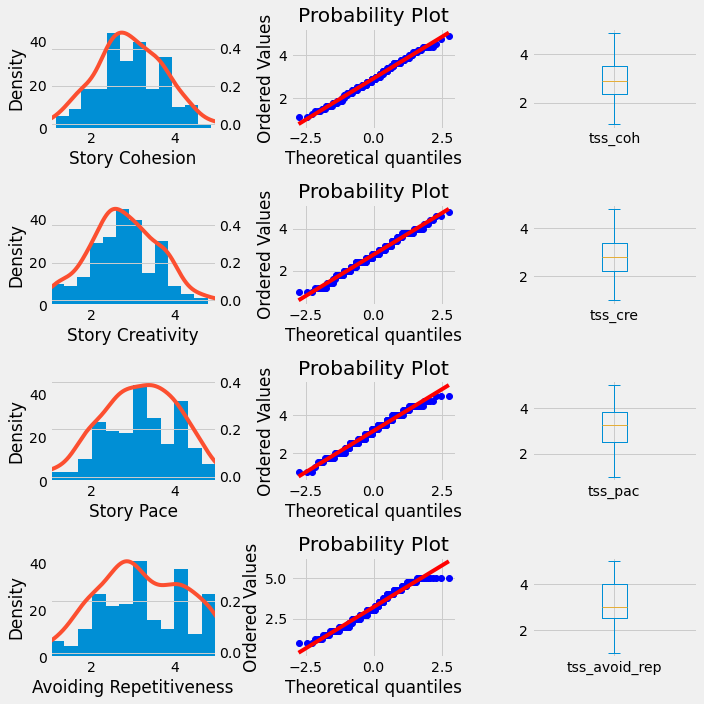

In [28]:
# Check scale distributions
fig, axes = plt.subplots(4, 3, figsize=(10, 10))

# Histograms with KDE
ax1 = tss_df["tss_coh"].plot.hist(ax=axes[0, 0], bins=12)
ax1.set_xlabel("Story Cohesion")
ax1.set_xlim(1, 5)
tss_df["tss_coh"].plot.kde(ax=axes[0, 0], secondary_y=True)

ax2 = tss_df["tss_cre"].plot.hist(ax=axes[1, 0], bins=12)
ax2.set_xlabel("Story Creativity")
ax2.set_xlim(1, 5)
tss_df["tss_cre"].plot.kde(ax=axes[1, 0], secondary_y=True)

ax3 = tss_df["tss_pac"].plot.hist(ax=axes[2, 0], bins=12)
tss_df["tss_pac"].plot.kde(ax=axes[2, 0], secondary_y=True)
ax3.set_xlabel("Story Pace")
ax3.set_xlim(1, 5)

ax4 = tss_df["tss_avoid_rep"].plot.hist(ax=axes[3, 0], bins=12)
tss_df["tss_avoid_rep"].plot.kde(ax=axes[3, 0], secondary_y=True)
ax4.set_xlabel("Avoiding Repetitiveness")
ax4.set_xlim(1, 5)

# Q-Q Plots
stats.probplot(tss_df["tss_coh"], dist="norm", plot=axes[0, 1])
stats.probplot(tss_df["tss_cre"], dist="norm", plot=axes[1, 1])
stats.probplot(tss_df["tss_pac"], dist="norm", plot=axes[2, 1])
stats.probplot(tss_df["tss_avoid_rep"], dist="norm", plot=axes[3, 1])

# Boxplots
tss_df["tss_coh"].plot.box(ax=axes[0, 2])
tss_df["tss_cre"].plot.box(ax=axes[1, 2])
tss_df["tss_pac"].plot.box(ax=axes[2, 2])
tss_df["tss_avoid_rep"].plot.box(ax=axes[3, 2])

fig.tight_layout()
plt.show()

In [29]:
tss_df[["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac"]].corr()

,tss_coh,tss_cre,tss_avoid_rep,tss_pac
tss_coh,1.000000,0.110771,0.110091,-0.121293
tss_cre,0.110771,1.000000,0.164430,0.143800
tss_avoid_rep,0.110091,0.164430,1.000000,0.239138
tss_pac,-0.121293,0.143800,0.239138,1.000000


<Figure size 720x720 with 0 Axes>

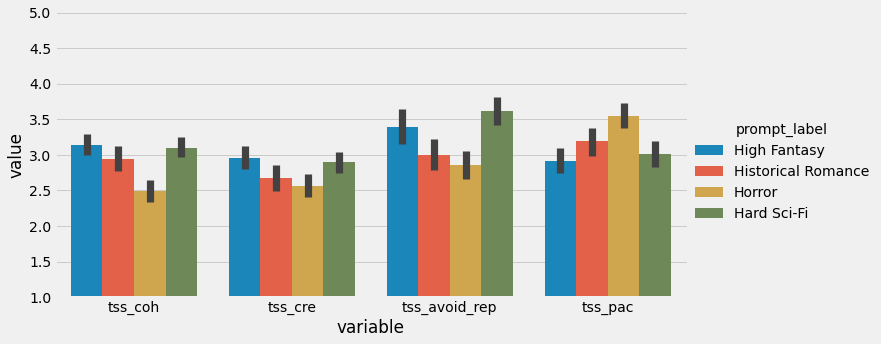

In [30]:
plt.figure(figsize=(10, 10))

tidy = tss_df[["response_id", "prompt_label", "tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac"]
              ].melt(id_vars=['response_id', "prompt_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="prompt_label",
                 ci=90, height=5, aspect=2)

plt.ylim(1, 5)

plt.show()

<Figure size 720x720 with 0 Axes>

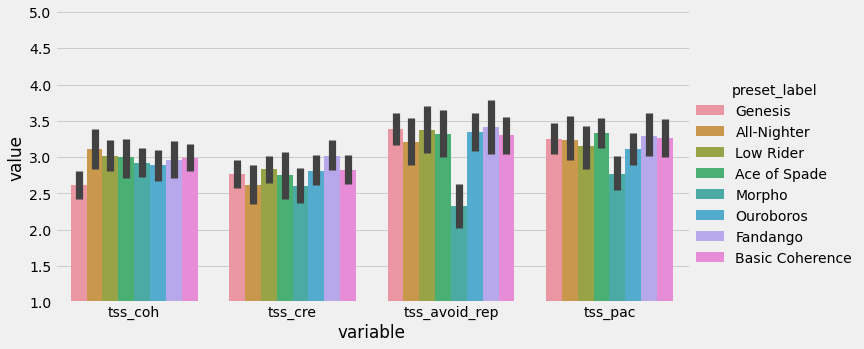

In [31]:
plt.figure(figsize=(10, 10))

tidy = tss_df[["response_id", "preset_label", "tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac"]
              ].melt(id_vars=['response_id', "preset_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="preset_label",
                 ci=90, height=5, aspect=2)

plt.ylim(1, 5)

plt.show()

<AxesSubplot:xlabel='word_count', ylabel='tss_cre'>

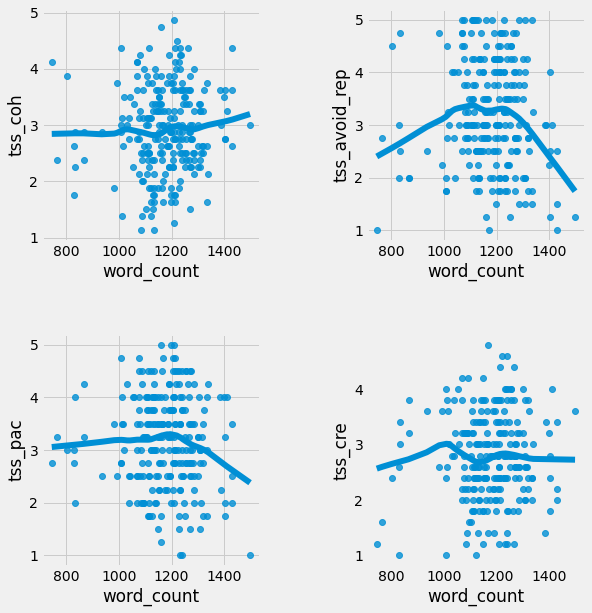

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.regplot(data=tss_df, y="tss_coh",
            x="word_count", lowess=True, ax=axes[0, 0])
sns.regplot(data=tss_df, y="tss_avoid_rep",
            x="word_count", lowess=True, ax=axes[0, 1])
sns.regplot(data=tss_df, y="tss_pac",
            x="word_count", lowess=True, ax=axes[1, 0])
sns.regplot(data=tss_df, y="tss_cre",
            x="word_count", lowess=True, ax=axes[1, 1])

In [33]:
# Setting up k-fold cross validation

kf = KFold(10, shuffle=True, random_state=42)

# Defining predictors for models
tss_df["words_cent"] = tss_df["word_count"].apply(
    lambda x: x-tss_df["word_count"].mean())  # centering

tss_df["words_cent**2"] = tss_df["words_cent"]*tss_df["words_cent"]
tss_df["words_cent**3"] = tss_df["words_cent"]**3
#tss_df["words_cent**4"] = tss_df["words_cent"]**4
#tss_df["words_cent**5"] = tss_df["words_cent"]**5

lin_model = linreg()

pred_li = [("linear", "words_cent"), ("quadratic", "words_cent**2"),
           ("cubic", "words_cent**3")]
#("quartic", "words_cent**4"),
# ("quintic", "words_cent**5")]
outcome_li = ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac"]


for outcome in outcome_li:
    y = tss_df[outcome]
    current_preds_col = []

    for pred in pred_li:
        current_preds_col.append(pred[1])
        x = tss_df.loc[:, current_preds_col]

        current_model_name = pred[0]

        cross_val = cross_validate(lin_model, x, y,
                                   scoring=["neg_mean_squared_error", "r2"], cv=kf)

        neg_mses = cross_val["test_neg_mean_squared_error"]
        r_squares = cross_val["test_r2"]
        avg_rmse = np.mean((neg_mses*-1)**0.5)
        avg_r_sq = np.mean(r_squares)
        print("Model performance for {} model predicting {}:".format(
            current_model_name, outcome))
        print("r-square: {:.4f}    RMSE: {:.4f}".format(avg_r_sq, avg_rmse))
    print("")

# word count is completly irrelevant to story ratings...
# if it stays this way I could just run a MANOVA

Model performance for linear model predicting tss_coh:
r-square: -0.0592    RMSE: 0.7671
Model performance for quadratic model predicting tss_coh:
r-square: -0.0665    RMSE: 0.7688
Model performance for cubic model predicting tss_coh:
r-square: -0.0870    RMSE: 0.7761

Model performance for linear model predicting tss_cre:
r-square: -0.1713    RMSE: 0.7898
Model performance for quadratic model predicting tss_cre:
r-square: -0.1888    RMSE: 0.7936
Model performance for cubic model predicting tss_cre:
r-square: -0.1863    RMSE: 0.7926

Model performance for linear model predicting tss_avoid_rep:
r-square: -0.0633    RMSE: 1.0271
Model performance for quadratic model predicting tss_avoid_rep:
r-square: 0.0073    RMSE: 0.9955
Model performance for cubic model predicting tss_avoid_rep:
r-square: -0.0000    RMSE: 1.0001

Model performance for linear model predicting tss_pac:
r-square: -0.1263    RMSE: 0.8832
Model performance for quadratic model predicting tss_pac:
r-square: -0.1145    RMSE:

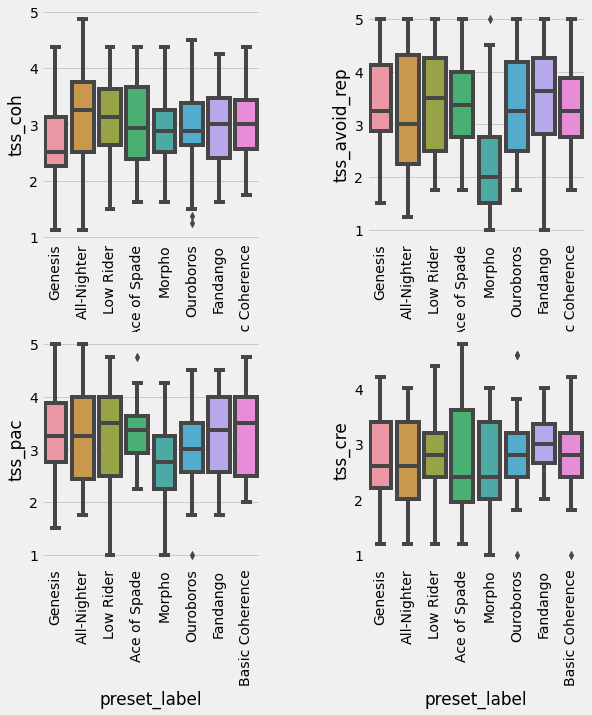

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.boxplot(x="preset_label", y="tss_coh", data=tss_df, ax=axes[0, 0])
sns.boxplot(x="preset_label", y="tss_avoid_rep", data=tss_df, ax=axes[0, 1])
sns.boxplot(x="preset_label", y="tss_pac", data=tss_df, ax=axes[1, 0])
sns.boxplot(x="preset_label", y="tss_cre", data=tss_df, ax=axes[1, 1])

for ax_1, ax_2 in axes:
    ax_1.set_xticklabels(ax_1.get_xticklabels(), rotation=90)
    ax_2.set_xticklabels(ax_2.get_xticklabels(), rotation=90)

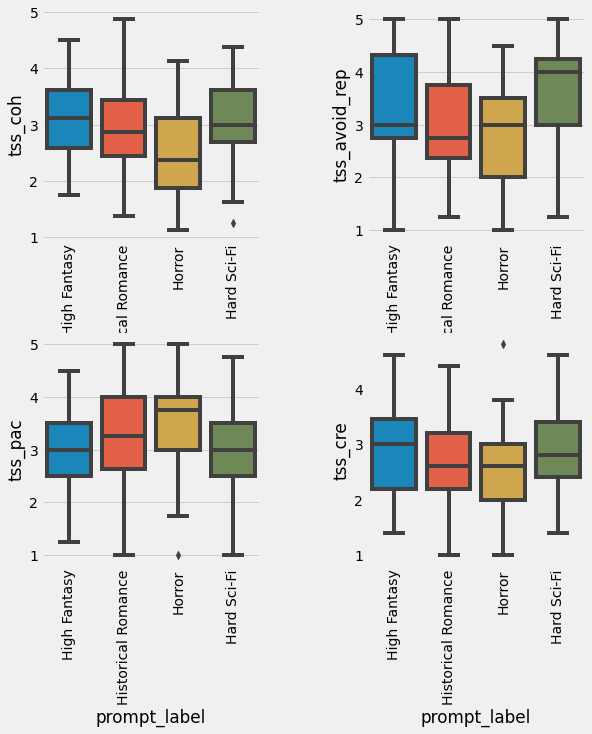

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.boxplot(x="prompt_label", y="tss_coh", data=tss_df, ax=axes[0, 0])
sns.boxplot(x="prompt_label", y="tss_avoid_rep", data=tss_df, ax=axes[0, 1])
sns.boxplot(x="prompt_label", y="tss_pac", data=tss_df, ax=axes[1, 0])
sns.boxplot(x="prompt_label", y="tss_cre", data=tss_df, ax=axes[1, 1])

for ax_1, ax_2 in axes:
    ax_1.set_xticklabels(ax_1.get_xticklabels(), rotation=90)
    ax_2.set_xticklabels(ax_2.get_xticklabels(), rotation=90)

In [36]:
def determine_outliers(df, var, distance=3, mode="print"):
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)

    iqr = q3-q1
    outlier_lower = q1 - (iqr*distance)
    outlier_upper = q3 + (iqr*distance)
    if mode == "print":
        print("25th Percentile (Q1): {:.2f}\n75th Percentile (Q3): {:.2f}\nIQR: {:.2f}".format(
            q1, q3, iqr))
        print("Will count cases as outlier with values less than {:.2f} or more than {:.2f}."
              .format(outlier_lower, outlier_upper))
        mask_outlier = (df[var] < outlier_lower) | (df[var] > outlier_upper)
        if df[mask_outlier].shape[0] == 0:
            print("With these criteria there are no outlier in the data")
        else:
            print("Showing outliers")
            print(df[mask_outlier][var])
    else:
        print("Mode must be 'print'")

In [37]:
# Outliers for Presets
# Outliers Coherence
print("Exterme outliers on tss_coh, Ouroboros preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Ouroboros"], "tss_coh")
# Outliers Repitition
print("\nExterme outliers on tss_rep, Morpho preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Morpho"], "tss_avoid_rep")
# Outliers pace
print("\nExterme outliers on tss_pac, Ace of Spades preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Ace of Spades"], "tss_pac")
print("\nExterme outliers on tss_pac, Ouroboros preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Ouroboros"], "tss_pac")
# Outliers creativity
print("\nExterme outliers on tss_cre, Basic Coherence preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Basic Coherence"], "tss_cre")
print("\nExterme outliers on tss_pac, Ouroboros preset")
determine_outliers(tss_df[tss_df["preset_label"] == "Ouroboros"], "tss_cre")

## Outliers for Prompts
# Coherence
print("\nExterme outliers on tss_coh, Hard Sci-Fi prompt")
determine_outliers(tss_df[tss_df["prompt_label"] == "Hard Sci-Fi"], "tss_coh")
# Pace
print("\nExterme outliers on tss_pac, Horror prompt")
determine_outliers(tss_df[tss_df["prompt_label"] == "Horror"], "tss_pac")
# Creativity
print("\nExterme outliers on tss_cre, Horror prompt")
determine_outliers(tss_df[tss_df["prompt_label"] == "Horror"], "tss_cre")

Exterme outliers on tss_coh, Ouroboros preset
25th Percentile (Q1): 2.62
75th Percentile (Q3): 3.38
IQR: 0.75
Will count cases as outlier with values less than 0.38 or more than 5.62.
With these criteria there are no outlier in the data

Exterme outliers on tss_rep, Morpho preset
25th Percentile (Q1): 1.50
75th Percentile (Q3): 2.75
IQR: 1.25
Will count cases as outlier with values less than -2.25 or more than 6.50.
With these criteria there are no outlier in the data

Exterme outliers on tss_pac, Ace of Spades preset
25th Percentile (Q1): nan
75th Percentile (Q3): nan
IQR: nan
Will count cases as outlier with values less than nan or more than nan.
With these criteria there are no outlier in the data

Exterme outliers on tss_pac, Ouroboros preset
25th Percentile (Q1): 2.56
75th Percentile (Q3): 3.50
IQR: 0.94
Will count cases as outlier with values less than -0.25 or more than 6.31.
With these criteria there are no outlier in the data

Exterme outliers on tss_cre, Basic Coherence prese

In [41]:
#tss_no_out = tss_df[~(tss_df.index == 7)].copy()
tss_no_out = tss_df

In [38]:
# Normality
def qqs_over_groups_and_vars(df, group_label, vars_li, size=(15, 15)):
    groups_li = df[group_label].unique()
    fig, axes = plt.subplots(len(vars_li), len(groups_li), figsize=size)
    fig.tight_layout(pad=5.0)
    plt.grid(False)

    x = 0
    y = 0
    for group, var in itertools.product(groups_li, vars_li):
        stats.probplot(df[df[group_label] == group][var],
                       dist="norm", plot=axes[y, x])
        axes[y, x].set_title(group + " - " + var)
        if x < (len(groups_li)-1):
            x += 1
        else:
            x = 0
            y += 1

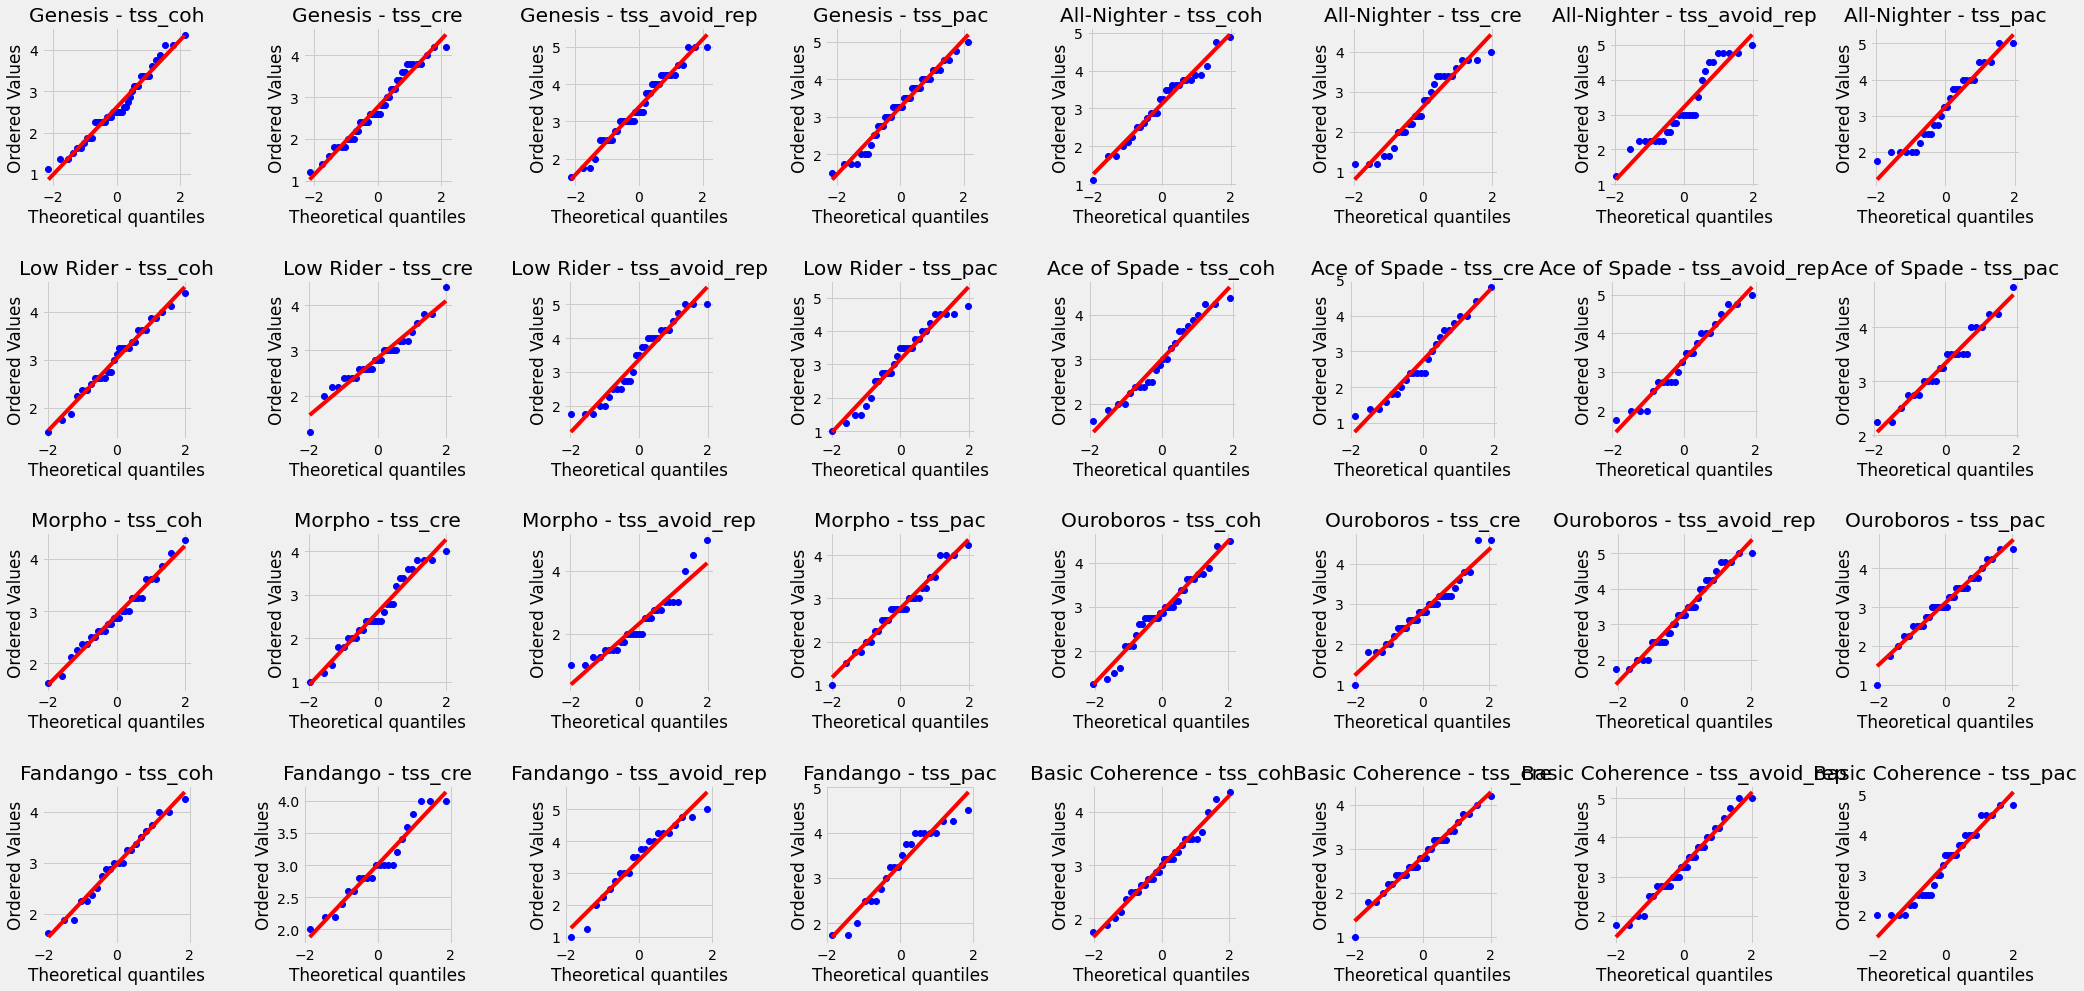

In [42]:
qqs_over_groups_and_vars(tss_no_out, "preset_label", outcome_li, size=(30, 15))

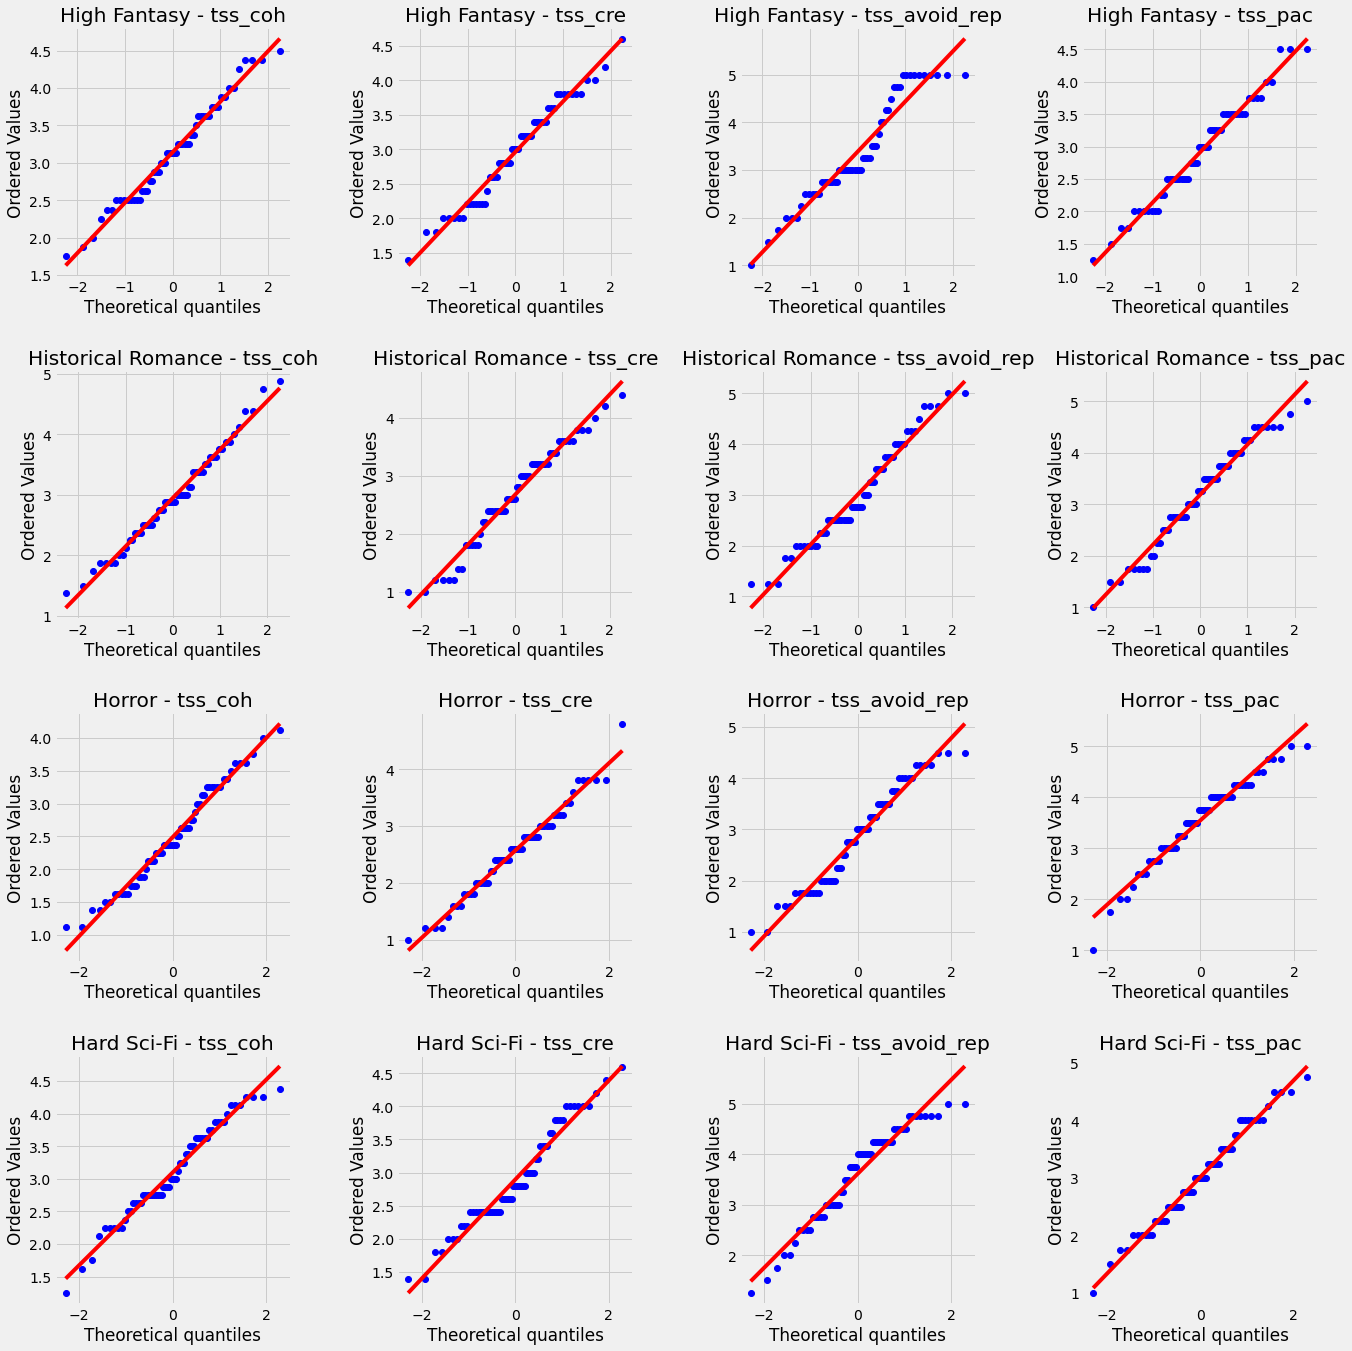

In [43]:
qqs_over_groups_and_vars(tss_no_out, "prompt_label", outcome_li, size=(20, 20))

In [44]:
# Checking if F-test ist robust to heteroscedacity
# Taking recommended approach from Blanca et al., 2018
def anova_check_homoscedacity(y_var, group_var, df):
    var_ser = pd.Series(index=df[group_var].unique(), dtype=float)

    for group in df[group_var].unique():
        var_ser[group] = df[df[group_var] == group][y_var].var()

    min_var = (var_ser.idxmin(), var_ser.min())
    max_var = (var_ser.idxmax(), var_ser.max())
    var_ratio = max_var[1]/min_var[1]
    print("Smallest variance for {}: {:.2f}".format(min_var[0], min_var[1]))
    print("Largest variance for {}: {:.2f}".format(max_var[0], max_var[1]))
    print("Variance ratio for: {:.2f}".format(var_ratio))

    if var_ratio <= 1.5:
        print("Variance ratio is smaller or equal to 1.5, F-test will be robust.")
        return
    else:
        print("Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.")

    # Create dataframe with variance and group sizes
    var_n_df = var_ser.to_frame(name="var")
    var_n_df["n"] = df.value_counts(subset=group_var)
    # get correlation between correlation and variance
    corr_var_n = var_n_df[["var", "n"]].corr().iloc[1, 0]

    if (corr_var_n >= 0) and (corr_var_n <= 0.5):
        print("Correlation between sample size and variance (pairing) is {:.2f}. That is between 0 and .5. F-test should be robust".
              format(corr_var_n))
        return
    else:
        print("Correlation between sample size and variance (pairing) is {:.2f}. That is below 0 or over .5.".
              format(corr_var_n), "Continuing with further checks...")

    # Compute coefficient of sample size variation
    coeff_n = var_n_df["var"].std()/var_n_df["var"].mean()
    if (corr_var_n > 0.5) and (coeff_n > .33) and (var_ratio > 2):
        print("Pairing is {:.2f}, so larger than .5,".format(corr_var_n),
              ",coefficient of sample size variation is {:.2f}, larger than .33,".format(
                  coeff_n),
              "and variance ratio is {:.2f}, larger than 2.".format(var_ratio),
              "F-test is too conserative (hurting power)")
    elif (corr_var_n < 0) and (corr_var_n >= -0.5) and (coeff_n > .16) and (var_ratio > 2):
        print("Pairing is {:.2f}, so smaller than 0 and larger than or equal to -.5,".format(corr_var_n),
              ",coefficient of sample size variation is {:.2f}, larger than .16,".format(
                  coeff_n),
              "and variance ratio is {:.2f}, larger than 2.".format(var_ratio),
              "F-test is too liberal (real alpha might be as high as .1 if variance ratio is 9 or smaller).")
    elif (corr_var_n < -0.5):
        print("Pairing is {:.2f}, so smaller than -.5.".format(corr_var_n),
              "F-test is too liberal (real alpha might be as high as .2 if variance ratio is 9 or smaller).")
    else:
        print("Pairing is {}, coefficient of sample size variation is {:.2f}, variance ratio is {}."
              .format(corr_var_n, coeff_n, var_ratio),
              "This specific combination should have robust F-test, but look into the paper",
              "('Effect of variance ratio on ANOVA robustness: Might 1.5 be the limit?', Blanca et al., 2018)",
              "to be sure.")

In [45]:
for outcome in outcome_li:
    print("Checks for {}".format(outcome))
    print("Preset")
    anova_check_homoscedacity(outcome, "preset_label", tss_no_out)
    print("\nPrompt")
    anova_check_homoscedacity(outcome, "prompt_label", tss_no_out)
    print("\n")

Checks for tss_coh
Preset
Smallest variance for Basic Coherence: 0.41
Largest variance for All-Nighter: 0.82
Variance ratio for: 1.99
Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.
Correlation between sample size and variance (pairing) is 0.03. That is between 0 and .5. F-test should be robust

Prompt
Smallest variance for High Fantasy: 0.44
Largest variance for Historical Romance: 0.62
Variance ratio for: 1.40
Variance ratio is smaller or equal to 1.5, F-test will be robust.


Checks for tss_cre
Preset
Smallest variance for Fandango: 0.35
Largest variance for Ace of Spade: 1.04
Variance ratio for: 2.99
Variance ratio is larger 1.5. Now doing additional checks to see if F-test is robust.
Correlation between sample size and variance (pairing) is -0.07. That is below 0 or over .5. Continuing with further checks...
Pairing is -0.07, so smaller than 0 and larger than or equal to -.5, ,coefficient of sample size variation is 0.37, larger than .16, and 

In [46]:
params_df = pd.DataFrame()

# if heteroscedacity, run with fit(cov_type='HC3') and anova_lm(anova_mod, typ=2, robust='HC3')

for outcome in outcome_li:
    print("\033[1m{}\033[0m".format(outcome))
    ols_formula = outcome + \
        " ~ C(preset_label, Sum) + C(prompt_label, Sum) + C(sample, Treatment(0))"
    ols_formula2 = outcome + \
        " ~ C(preset_label, Sum(0)) + C(prompt_label, Sum(0)) + C(sample, Treatment(0))"
    anova_mod = ols(
        ols_formula, tss_no_out).fit(cov_type='HC3')
    anova_mod2 = ols(
        ols_formula2, tss_no_out).fit(cov_type='HC3')
    print(sm.stats.anova_lm(anova_mod, typ=2, robust='HC3'))
    print(anova_mod.summary(alpha=0.1))

    print("\nDeviation contrasts for\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[7], anova_mod2.params[7], anova_mod2.pvalues[7]),
          "\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[10], anova_mod2.params[10], anova_mod2.pvalues[10]))
    print("\n")

    params_df[outcome] = anova_mod.params
    params_df[outcome + " p-value"] = anova_mod.pvalues
    params_df[outcome + " 90% CI Lower"] = anova_mod.conf_int(alpha=0.1)[0]

    params_df.loc[anova_mod2.params.index[7], outcome] = anova_mod2.params[7]
    params_df.loc[anova_mod2.params.index[7],
                  outcome + " p-value"] = anova_mod2.pvalues[7]
    params_df.loc[anova_mod2.params.index[7], outcome +
                  " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][7]

    params_df.loc[anova_mod2.params.index[10], outcome] = anova_mod2.params[10]
    params_df.loc[anova_mod2.params.index[10],
                  outcome + " p-value"] = anova_mod2.pvalues[10]
    params_df.loc[anova_mod2.params.index[10], outcome +
                  " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][10]

tss_coh
                             sum_sq     df         F    PR(>F)
C(preset_label, Sum)       4.645739    7.0  1.261232  0.270626
C(prompt_label, Sum)      15.366566    3.0  9.734057  0.000005
C(sample, Treatment(0))    0.059345    1.0  0.112778  0.737312
Residual                 119.976597  228.0       NaN       NaN
                            OLS Regression Results                            
Dep. Variable:                tss_coh   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     3.964
Date:                Fri, 25 Mar 2022   Prob (F-statistic):           2.75e-05
Time:                        12:14:22   Log-Likelihood:                -257.34
No. Observations:                 240   AIC:                             538.7
Df Residuals:                     228   BIC:                             580.5
Df Model:                          11        

                            OLS Regression Results                            
Dep. Variable:                tss_pac   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     3.662
Date:                Fri, 25 Mar 2022   Prob (F-statistic):           8.41e-05
Time:                        12:14:22   Log-Likelihood:                -292.44
No. Observations:                 240   AIC:                             608.9
Df Residuals:                     228   BIC:                             650.7
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                                                 coef    std err          z      P>|z|       [0.05       0.95]
---------------------------------------------------------------------------------------------------

In [47]:
params_df.index = params_df.index.str.replace(
    r'C\(.*[ST]\.(.*)\]', r'\1', regex=True)

# Transform 90% CI lower bound to 90% CI margin of error
for outcome in outcome_li:
    params_df[outcome + " 90% CI Lower"] = params_df[outcome] - \
        params_df[outcome + " 90% CI Lower"]
params_df.columns = params_df.columns.str.replace(
    "90% CI Lower", "90% CI margin", regex=False)

presets_li = list(tss_no_out["preset_label"].unique())
prompts_li = list(tss_no_out["prompt_label"].unique())

order_index = ["Intercept"]
order_index.extend(presets_li)
order_index.extend(prompts_li)

params_df = params_df.reindex(order_index)

cols_order = []

for outcome in outcome_li:
    # adjusted ps for presets
    params_df.loc[presets_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[presets_li, outcome + " p-value"], alpha=0.1)[1]
    # adjusted ps for prompts
    params_df.loc[prompts_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[prompts_li, outcome + " p-value"], alpha=0.1)[1]

    cols_order.extend([outcome, outcome + " p-value",
                       outcome + " adj_p", outcome + " 90% CI margin"])

params_df = params_df[cols_order]

In [160]:
params_df

,tss_coh,tss_coh p-value,tss_coh adj_p,tss_coh 90% CI margin,tss_cre,tss_cre p-value,tss_cre adj_p,tss_cre 90% CI margin,tss_avoid_rep,tss_avoid_rep p-value,tss_avoid_rep adj_p,tss_avoid_rep 90% CI margin,tss_pac,tss_pac p-value,tss_pac adj_p,tss_pac 90% CI margin
Intercept,2.898807,0.000000e+00,NaN,0.110538,2.562351,1.266414e-226,NaN,0.131140,3.337513,0.000000e+00,NaN,0.141642,3.287859,0.000000,NaN,0.141765
Genesis,-0.373240,3.329940e-04,0.002664,0.171097,-0.166363,2.486609e-01,0.818458,0.237207,0.173719,2.188365e-01,4.080414e-01,0.232381,0.007885,0.956089,0.956089,0.235561
All-Nighter,0.213474,1.639255e-01,0.655702,0.252253,-0.027069,8.717454e-01,0.989927,0.275794,-0.096273,5.810738e-01,6.640843e-01,0.286970,0.063335,0.720500,0.907651,0.291168
Low Rider,0.129078,3.405760e-01,0.908203,0.222779,0.100052,5.115363e-01,0.818458,0.250698,0.290441,6.726931e-02,2.690772e-01,0.261075,-0.053566,0.794195,0.907651,0.337752
Ace of Spade,0.100388,4.747132e-01,0.949426,0.230996,0.131163,5.101958e-01,0.818458,0.327614,0.104874,5.441656e-01,6.640843e-01,0.284410,0.192718,0.185680,0.558432,0.239517
Morpho,-0.003232,9.786753e-01,0.978675,0.198904,-0.237172,1.537773e-01,0.818458,0.273511,-0.939357,7.913985e-13,6.331188e-12,0.215717,-0.376948,0.014835,0.118679,0.254485
Ouroboros,-0.063117,6.035489e-01,0.965678,0.199918,0.058044,6.852007e-01,0.913601,0.235518,0.210538,2.117090e-01,4.080414e-01,0.277292,-0.173032,0.299283,0.598567,0.274201
Fandango,-0.025267,8.670393e-01,0.978675,0.248245,0.143322,4.685550e-01,0.818458,0.325240,0.083606,6.870568e-01,6.870568e-01,0.341364,0.240256,0.209412,0.558432,0.314843
Basic Coherence,0.021917,8.475928e-01,0.978675,0.187579,-0.001976,9.899271e-01,0.989927,0.257482,0.172452,2.550259e-01,4.080414e-01,0.249210,0.099351,0.541782,0.866852,0.267846
High Fantasy,0.183712,3.087908e-02,0.041172,0.139987,0.153732,1.528072e-01,0.305614,0.176869,0.191157,7.160534e-02,9.547379e-02,0.174523,-0.149998,0.165560,0.245788,0.177933


In [48]:
tss_no_out["preset_label"].value_counts()

Genesis            43
Ouroboros          34
Basic Coherence    31
Low Rider          29
Morpho             29
All-Nighter        28
Ace of Spade       24
Fandango           22
Name: preset_label, dtype: int64

In [162]:
# labels = ["Coherence", "Creativity", "Avoiding Repitition", "Pace"]

# # create dicts with a key for each preset with an empty list as value for each
# marginal_means_dict = {preset: [] for preset in params_df[1:8].index}
# yerr_dict = {preset: [] for preset in params_df[1:8].index}
# #colors = ["tab:blue", "tab:green", "tab:red", "tab:orange"]

# for preset, outcome in itertools.product(marginal_means_dict.keys(), outcome_li):
#     marginal_means_dict[preset].append(params_df.loc["Intercept", outcome] + params_df.loc[preset, outcome])
#     yerr_dict[preset].append(params_df.loc[preset, outcome + " 90% CI margin"])

# figure = plt.figure(figsize=(10, 5))

# x = np.arange(len(labels)) # label locations
# width = 0.35 # width of bars

# plt.bar(x-width/2, marginal_means_dict["Genesis"], width,
#         yerr = yerr_dict["Genesis"], label = "Genesis", color = "tab:blue")
# plt.bar(x+width/2, marginal_means_dict["Ouroboros"], width,
#         yerr = yerr_dict["Ouroboros"], label = "Ouroboros", color = "tab:orange")


# i = 0
# pos = -0.4
# for outcome in outcome_li:
#     grand_mean = params_df.loc["Intercept", outcome]
#     ax = plt.plot([pos, pos+0.8], [grand_mean, grand_mean], '--', color = "black", alpha = 0.65)
#     if i == 0:
#         ax[0].set_label("Grand Mean (all Presets)")
#     i += 1
#     pos += 1

# plt.ylim(1,5)
# plt.ylabel("Marginal Means (Community Sample)", fontsize = 16)
# plt.xticks(x, labels, fontsize = 16)

# plt.legend(frameon=False, fontsize = 16, loc='upper center', ncol = 3)
# leg = plt.gca().get_legend()
# plt.grid(False)
# #plt.title("Genesis & Low Rider")
# #figure.tight_layout()
# plt.show()

# figure.savefig('graphs/gen_our_1.png', bbox_inches="tight")

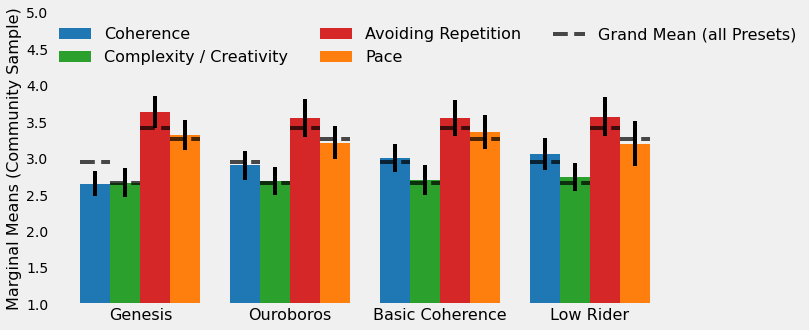

In [56]:
labels = ["Coherence", "Complexity / Creativity", "Avoiding Repitition", "Pace"]

# create dicts with a key for each outcome with an empty list as value for each
marginal_means_dict = {outcome: [] for outcome in outcome_li}
yerr_dict = {outcome: [] for outcome in outcome_li}
colors = ["darkblue", "darkgreen", "darkred", "darkorange"]

for preset, outcome in itertools.product(["Genesis", "Ouroboros", "Basic Coherence", "Low Rider"], outcome_li):
    marginal_means_dict[outcome].append(
        params_df.loc["Intercept", outcome] + params_df.loc[preset, outcome])
    yerr_dict[outcome].append(
        params_df.loc[preset, outcome + " 90% CI margin"])

figure = plt.figure(figsize=(10, 5))

x = np.arange(len(marginal_means_dict["tss_cre"]))  # label locations
width = 0.2  # width of bars

plt.bar(x-0.3, marginal_means_dict["tss_coh"], width,
        yerr=yerr_dict["tss_coh"], label="Coherence", color="tab:blue")

plt.bar(x-0.1, marginal_means_dict["tss_cre"], width,
        yerr=yerr_dict["tss_cre"], label="Complexity / Creativity", color="tab:green")

plt.bar(x+0.1, marginal_means_dict["tss_avoid_rep"], width,
        yerr=yerr_dict["tss_avoid_rep"], label="Avoiding Repetition", color="tab:red")

plt.bar(x+0.3, marginal_means_dict["tss_pac"], width,
        yerr=yerr_dict["tss_pac"], label="Pace", color="tab:orange")

plt.ylim(1, 5)
plt.ylabel("Marginal Means (Community Sample)", fontsize=16)
plt.xticks(x, ["Genesis", "Ouroboros", "Basic Coherence", "Low Rider"], fontsize=16)

outcome_i = 0
pos = -0.4
for outcome in outcome_li:
    grand_mean = params_df.loc["Intercept", outcome]
    for preset_i in range(0, len(plt.gca().get_xticks())):
        ax = plt.plot([pos+preset_i, pos+width+preset_i],
                      [grand_mean, grand_mean], '--', color="black", alpha=0.7)
    if outcome_i == 0:
        ax[0].set_label("Grand Mean (all Presets)")
    outcome_i += 1
    pos += width


handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 3, 4, 0]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           frameon=False, fontsize=16, loc='upper center', ncol=3, bbox_to_anchor=(0.6, 1))
# plt.legend(frameon=False, bbox_to_anchor = (1,.9), fontsize = 16)
plt.grid(False)
#plt.title("Genesis & Low Rider")
# figure.tight_layout()
plt.show()

figure.savefig('graphs/gen_presets_preview.png', bbox_inches="tight")

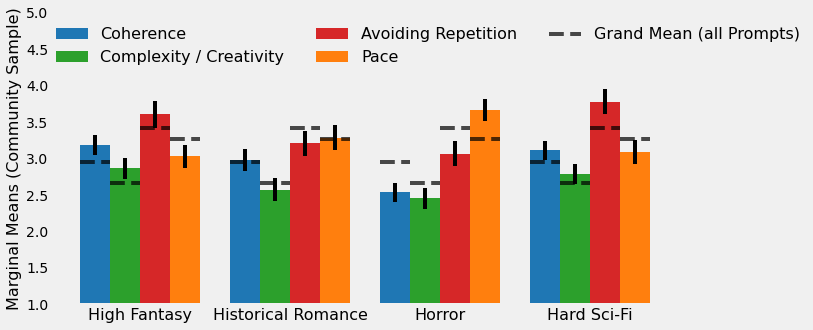

In [57]:
# Create graph for prompts

# create dicts with a key for each outcome with an empty list as value for each
marginal_means_dict = {outcome: [] for outcome in outcome_li}
yerr_dict = {outcome: [] for outcome in outcome_li}
colors = ["darkblue", "darkgreen", "darkred", "darkorange"]

for prompt, outcome in itertools.product(prompts_li, outcome_li):
    marginal_means_dict[outcome].append(
        params_df.loc["Intercept", outcome] + params_df.loc[prompt, outcome])
    yerr_dict[outcome].append(
        params_df.loc[prompt, outcome + " 90% CI margin"])

figure = plt.figure(figsize=(10, 5))

x = np.arange(len(marginal_means_dict["tss_cre"]))  # label locations
width = 0.2  # width of bars

plt.bar(x-0.3, marginal_means_dict["tss_coh"], width,
        yerr=yerr_dict["tss_coh"], label="Coherence", color="tab:blue")

plt.bar(x-0.1, marginal_means_dict["tss_cre"], width,
        yerr=yerr_dict["tss_cre"], label="Complexity / Creativity", color="tab:green")

plt.bar(x+0.1, marginal_means_dict["tss_avoid_rep"], width,
        yerr=yerr_dict["tss_avoid_rep"], label="Avoiding Repetition", color="tab:red")

plt.bar(x+0.3, marginal_means_dict["tss_pac"], width,
        yerr=yerr_dict["tss_pac"], label="Pace", color="tab:orange")

plt.ylim(1, 5)
plt.ylabel("Marginal Means (Community Sample)", fontsize=16)
plt.xticks(x, prompts_li, fontsize=16)

outcome_i = 0
pos = -0.4
for outcome in outcome_li:
    grand_mean = params_df.loc["Intercept", outcome]
    for preset_i in range(0, len(plt.gca().get_xticks())):
        ax = plt.plot([pos+preset_i, pos+width+preset_i],
                      [grand_mean, grand_mean], '--', color="black", alpha=0.7)
    if outcome_i == 0:
        ax[0].set_label("Grand Mean (all Prompts)")
    outcome_i += 1
    pos += width


handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 3, 4, 0]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           frameon=False, fontsize=16, loc='upper center', ncol=3, bbox_to_anchor=(0.6, 1))
# plt.legend(frameon=False, bbox_to_anchor = (1,.9), fontsize = 16)
plt.grid(False)
#plt.title("Genesis & Low Rider")
# figure.tight_layout()
plt.show()

figure.savefig('graphs/gen_prompts.png', bbox_inches="tight")

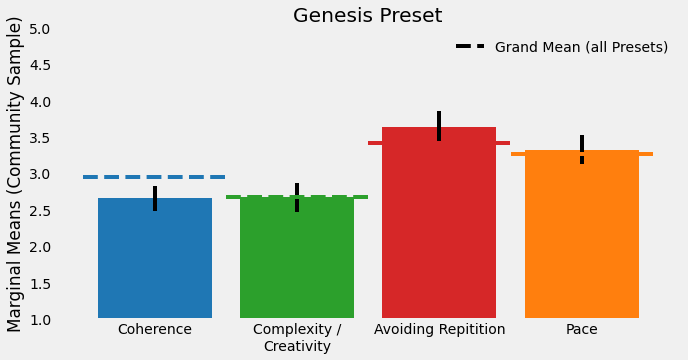

In [58]:
genesis_marginal_means = []
genesis_yerr = []
colors = ["tab:blue", "tab:green", "tab:red", "tab:orange"]

for outcome in outcome_li:
    genesis_marginal_means.append(
        params_df.loc["Intercept", outcome] + params_df.loc["Genesis", outcome])
    genesis_yerr.append(params_df.loc["Genesis", outcome + " 90% CI margin"])


figure = plt.figure(figsize=(10, 5))

plt.bar(["Coherence", "Complexity /\nCreativity", "Avoiding Repitition", "Pace"], genesis_marginal_means, yerr=genesis_yerr,
        color=colors)

i = 0
pos = -0.5
for outcome in outcome_li:
    grand_mean = params_df.loc["Intercept", outcome]
    ax = plt.plot([pos, pos+1], [grand_mean, grand_mean],
                  '--', color=colors[i])
    if i == 0:
        ax[0].set_label("Grand Mean (all Presets)")
    i += 1
    pos += 1

plt.ylim(1, 5)
plt.ylabel("Marginal Means (Community Sample)")

plt.legend(frameon=False)
leg = plt.gca().get_legend()
leg.legendHandles[0].set_color('black')
plt.grid(False)
plt.title("Genesis Preset")
plt.show()
figure.savefig('graphs/genesis.png', bbox_inches="tight")

In [59]:
tss_no_out[["tss_coh", "tss_avoid_rep", "tss_pac", "tss_cre",
            "tss_cre_4",
            "tss_qua_1", "tss_qua_2", "tss_qua_3", "tss_qua_5", "tss_qua_6", "tss_qua_7", "tss_qua_8"]].corr(method="kendall")

,tss_coh,tss_avoid_rep,tss_pac,tss_cre,tss_cre_4,tss_qua_1,tss_qua_2,tss_qua_3,tss_qua_5,tss_qua_6,tss_qua_7,tss_qua_8
tss_coh,1.000000,0.074324,-0.102565,0.083281,-0.012291,0.271418,0.284577,0.214693,0.185189,0.319937,0.284283,0.332009
tss_avoid_rep,0.074324,1.000000,0.190075,0.099651,0.135223,0.202443,0.183806,0.193719,0.148546,0.139822,0.187109,0.163703
tss_pac,-0.102565,0.190075,1.000000,0.106995,0.221617,0.149680,0.035605,0.217382,0.153352,0.094807,0.080927,0.017279
tss_cre,0.083281,0.099651,0.106995,1.000000,0.420216,0.356407,0.486985,0.404624,0.496621,0.436081,0.431325,0.457757
tss_cre_4,-0.012291,0.135223,0.221617,0.420216,1.000000,0.349770,0.287388,0.366087,0.342885,0.340658,0.280637,0.288262
tss_qua_1,0.271418,0.202443,0.149680,0.356407,0.349770,1.000000,0.491212,0.696322,0.341716,0.693229,0.570244,0.490500
tss_qua_2,0.284577,0.183806,0.035605,0.486985,0.287388,0.491212,1.000000,0.504285,0.446505,0.569352,0.570123,0.674786
tss_qua_3,0.214693,0.193719,0.217382,0.404624,0.366087,0.696322,0.504285,1.000000,0.388002,0.712481,0.603448,0.494132
tss_qua_5,0.185189,0.148546,0.153352,0.496621,0.342885,0.341716,0.446505,0.388002,1.000000,0.352634,0.352482,0.421305
tss_qua_6,0.319937,0.139822,0.094807,0.436081,0.340658,0.693229,0.569352,0.712481,0.352634,1.000000,0.626154,0.573674


In [60]:
items_descr[["tss_cre_4", "tss_qua_1", "tss_qua_2", "tss_qua_3",
             "tss_qua_5", "tss_qua_6", "tss_qua_7", "tss_qua_8"]]

item_label
tss_cre_4                             The story was creative.
tss_qua_1                           This story was enjoyable.
tss_qua_2                      This story is of high quality.
tss_qua_3                          The story was fun to read.
tss_qua_5                               The story felt vivid.
tss_qua_6                                 I liked this story.
tss_qua_7    I would like to read more stories like this one.
tss_qua_8                         The story was well-written.
Name: item description, dtype: object

In [65]:
tss_no_out["qual_2_agree+"] = tss_no_out["tss_qua_2"].apply(
    lambda x: 1 if x >= 4 else 0)
tss_no_out["qual_1_agree+"] = tss_no_out["tss_qua_1"].apply(
    lambda x: 1 if x >= 4 else 0)

In [80]:
# Center preds and prepare polynomial arrays
unc_pred_names_li = ["word_count", "tss_coh",
                     "tss_cre", "tss_avoid_rep", "tss_pac"]
cent_pred_names_li = []

# Defining predictors for models
for pred in unc_pred_names_li:
    cent_pred = pred + "_cent"
    tss_no_out[cent_pred] = tss_no_out[pred].apply(
        lambda x: x-tss_no_out[pred].mean())  # centering
    cent_pred_names_li.append(cent_pred)

lin_pred_data = tss_no_out[cent_pred_names_li].to_numpy()

poly_lin = polyfeat(interaction_only=True, include_bias=False)
lin_int_pred_data = poly_lin.fit_transform(lin_pred_data)

quad_pred_data = np.hstack((lin_pred_data, lin_pred_data**2))
cub_pred_data = np.hstack((lin_pred_data, lin_pred_data**2, lin_pred_data**3))
quart_pred_data = np.hstack(
    (lin_pred_data, lin_pred_data**2, lin_pred_data**3, lin_pred_data**4))

# Setting up k-fold cross validation
kf = KFold(10, shuffle=True, random_state=42)

log_model = logreg(max_iter=1000)

# setup list of model names with predictor arrays
poly_preds_li = [("linear", lin_pred_data), ("linear with interactions", lin_int_pred_data),
                 ("quadratic", quad_pred_data),
                 ("cubic", cub_pred_data), ("quartic", quart_pred_data)]

qua_li = ["qual_1_agree+", "qual_2_agree+"]

for qual_measure in qua_li:
    for poly_pred in poly_preds_li:
        y = tss_no_out[qual_measure]
        current_pred = poly_pred[1]
        current_model_name = poly_pred[0]
        cross_val = cross_validate(log_model, current_pred, y,
                                   scoring=["neg_log_loss"], cv=kf)
        # get negative loss scores, throw out nans if we got some
        nll = cross_val["test_neg_log_loss"]
        nll = nll[~np.isnan(nll)]
        avg_nll = np.mean(nll)
        print("Model performance for {} model predicting good or better output for {}:".format(
            current_model_name, qual_measure))
        print("negative log loss:{:.4f}\n".format(avg_nll))
    print("")

    # linear without interactions performs best

Model performance for linear model predicting good or better output for qual_1_agree+:
negative log loss:-0.5397

Model performance for linear with interactions model predicting good or better output for qual_1_agree+:
negative log loss:-0.5637

Model performance for quadratic model predicting good or better output for qual_1_agree+:
negative log loss:-0.5563

Model performance for cubic model predicting good or better output for qual_1_agree+:
negative log loss:-0.6720

Model performance for quartic model predicting good or better output for qual_1_agree+:
negative log loss:-0.6729




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 2391, in log_loss
    raise ValueError(
ValueError: y_true contains only one label (0). Please provide the true labels explicitly through the labels argument.

  warnings

Model performance for linear model predicting good or better output for qual_2_agree+:
negative log loss:-0.3330



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 2391, in log_loss
    raise ValueError(
ValueError: y_true contains only one label (0). Please provide the true labels explicitly through the labels argument.

  warnings

Model performance for linear with interactions model predicting good or better output for qual_2_agree+:
negative log loss:-0.3675



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 2391, in log_loss
    raise ValueError(
ValueError: y_true contains only one label (0). Please provide the true labels explicitly through the labels argument.

  warnings

Model performance for quadratic model predicting good or better output for qual_2_agree+:
negative log loss:-0.3418

Model performance for cubic model predicting good or better output for qual_2_agree+:
negative log loss:-0.5920



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 2391, in log_loss
    raise ValueError(
ValueError: y_true contains only one label (0). Please provide the true labels explicitly through the labels argument.

  warnings

Model performance for quartic model predicting good or better output for qual_2_agree+:
negative log loss:-0.6526




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 309, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 2391, in log_loss
    raise ValueError(
ValueError: y_true contains only one label (0). Please provide the true labels explicitly through the labels argument.

  warnings

In [121]:
log_reg_q1 = smf.logit(("Q('qual_1_agree+') ~ word_count_cent + tss_coh_cent" +
                     "+ tss_cre_cent + tss_avoid_rep_cent + tss_pac_cent" +
                       "+ C(sample, Treatment(0))"),
                    data=tss_no_out).fit()
log_reg_q2 = smf.logit(("Q('qual_2_agree+') ~ word_count_cent + tss_coh_cent" +
                     "+ tss_cre_cent + tss_avoid_rep_cent + tss_pac_cent" +
                       "+ C(sample, Treatment(0))"),
                    data=tss_no_out).fit()

print("\n\033[1mQuality Item 1 (Enjoyment)\033[0m")
print(log_reg_q1.summary())
print("\n\033[1mQuality Item 2 (High Quality)\033[0m")
print(log_reg_q2.summary())

Optimization terminated successfully.
         Current function value: 0.503350
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.273956
         Iterations 8

Quality Item 1 (Enjoyment)
                           Logit Regression Results                           
Dep. Variable:     Q('qual_1_agree+')   No. Observations:                  240
Model:                          Logit   Df Residuals:                      233
Method:                           MLE   Df Model:                            6
Date:                Fri, 25 Mar 2022   Pseudo R-squ.:                  0.2367
Time:                        13:52:30   Log-Likelihood:                -120.80
converged:                       True   LL-Null:                       -158.26
Covariance Type:            nonrobust   LLR p-value:                 4.019e-14
                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

In [116]:
logreg_li = [("Quality 1 (Enjoyment)", log_reg_q1), ("Quality 2 (High Quality)", log_reg_q2)]

for log_reg in logreg_li:
    print(f"Predictions & Performance for {log_reg[0]}")
    pred_table = log_reg[1].pred_table()

    # read out table values
    tn = pred_table[0, 0]
    tp = pred_table[1, 1]
    fn = pred_table[1, 0]
    fp = pred_table[0, 1]
    total = np.sum(pred_table)

    # Observed Probability
    obs_p = (tp + fn) / total

    # predicted prob
    pred_prob = (tp + fp) / total

    # Accuracy: Correct classification over all cases
    acc = (tp + tn) / total

    # Precision: Accuracy for data predicted to be positive
    prec = tp / (tp+fp)
    # Recall: Accuracy for positive (enjoyable/high quality) data
    rec = tp / (tp+fn)
    
    odds_ratio = np.exp(log_reg[1].params)

    print(f"Observed Probability: {obs_p:.2f}\n"
          f"Predicted Probability: {pred_prob:.2f}\n\n"
          f"Model Performance\n"
          f"Accuracy: {acc:.2f}\n"
          f"Precision: {prec:.2f}\n"
          f"Recall: {rec:.2f}\n"
          f"\nOdds Ratio:\n{odds_ratio}\n")

Predictions & Performance for Quality 1 (Enjoyment)
Observed Probability: 0.37
Predicted Probability: 0.33

Model Performance
Accuracy: 0.75
Precision: 0.68
Recall: 0.61

Odds Ratio:
Intercept                           0.338665
C(sample, Treatment(0))[T.Panel]    2.075552
word_count_cent                     1.003530
tss_coh_cent                        2.463158
tss_cre_cent                        2.751579
tss_avoid_rep_cent                  1.673477
tss_pac_cent                        1.795925
dtype: float64

Predictions & Performance for Quality 2 (High Quality)
Observed Probability: 0.16
Predicted Probability: 0.10

Model Performance
Accuracy: 0.88
Precision: 0.71
Recall: 0.44

Odds Ratio:
Intercept                           0.036471
C(sample, Treatment(0))[T.Panel]    2.803341
word_count_cent                     1.004168
tss_coh_cent                        2.862180
tss_cre_cent                        8.714861
tss_avoid_rep_cent                  2.516644
tss_pac_cent                  

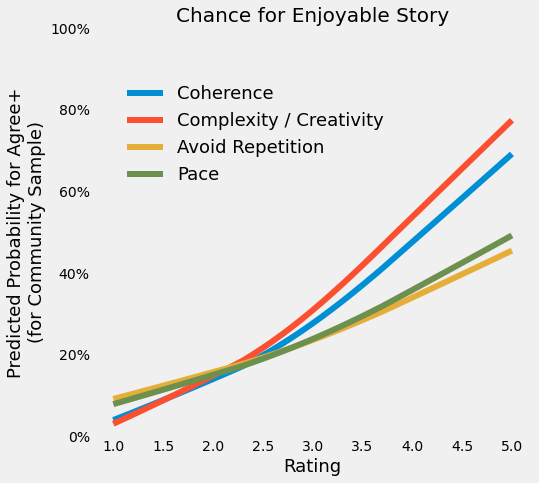

In [137]:
pred_df_template = pd.DataFrame()
pred_df_template["plot_values"] = np.arange(1.0, 5.1, 0.1)
pred_df_template[["tss_coh_cent", "tss_cre_cent",
                  "tss_avoid_rep_cent", "tss_pac_cent", "word_count_cent"]] = 0
pred_df_template["sample"] = "Community"

pred_vars = [("Coherence", "tss_coh"), ("Complexity / Creativity", "tss_cre"),
            ("Avoid Repetition", "tss_avoid_rep"), ("Pace", "tss_pac")]

fig, ax = plt.subplots(figsize=(7, 7))

for var in pred_vars:
    # Construct prediction df
    pred_df = pred_df_template.copy()
    var_full = var[0]
    var_short = var[1]
    pred_df.rename(columns = {"plot_values": var_full}, inplace = True)
    pred_df[var_short + "_cent"] = pred_df[var_full] - tss_no_out[var_short].mean()
    pred_df["Pred. Prob Qual 1"] = log_reg_q1.predict(pred_df)

    pred_plot = sns.regplot(data=pred_df, y="Pred. Prob Qual 1",
                            x=var_full, scatter=False, ax=ax, label=var_full,
                            x_ci=None, lowess=True)

plt.grid(False)
#plt.xlim(100, 2000)
plt.ylim(0, 1.0)
plt.ylabel("Predicted Probability for Agree+\n(for Community Sample)")
plt.xlabel("Rating")
ax.legend(fontsize=18, frameon = False, bbox_to_anchor = (.7,.9))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.xaxis.label.set_fontsize(18)
ax.yaxis.label.set_fontsize(18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Chance for Enjoyable Story", fontsize=20)
plt.savefig("graphs/logreg_qual_1.png", bbox_inches="tight")
plt.show()

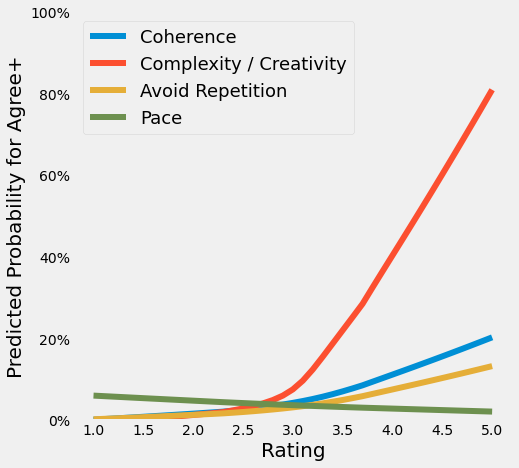

In [119]:
pred_df_template = pd.DataFrame()
pred_df_template["plot_values"] = np.arange(1.0, 5.1, 0.1)
pred_df_template[["tss_coh_cent", "tss_cre_cent",
                  "tss_avoid_rep_cent", "tss_pac_cent", "word_count_cent"]] = 0
pred_df_template["sample"] = "Community"

pred_vars = [("Coherence", "tss_coh"), ("Complexity / Creativity", "tss_cre"),
            ("Avoid Repetition", "tss_avoid_rep"), ("Pace", "tss_pac")]

fig, ax = plt.subplots(figsize=(7, 7))

for var in pred_vars:
    # Construct prediction df
    pred_df = pred_df_template.copy()
    var_full = var[0]
    var_short = var[1]
    pred_df.rename(columns = {"plot_values": var_full}, inplace = True)
    pred_df[var_short + "_cent"] = pred_df[var_full] - tss_no_out[var_short].mean()
    pred_df["Pred. Prob Qual 2"] = log_reg_q2.predict(pred_df)

    pred_plot = sns.regplot(data=pred_df, y="Pred. Prob Qual 2",
                            x=var_full, scatter=False, ax=ax, label=var_full,
                            x_ci=None, lowess=True)

plt.grid(False)
#plt.xlim(100, 2000)
plt.ylim(0, 1.0)
plt.ylabel("Predicted Probability for Agree+")
plt.xlabel("Rating")
ax.legend(fontsize=18)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
    #plt.savefig("l.png", bbox_inches="tight")
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

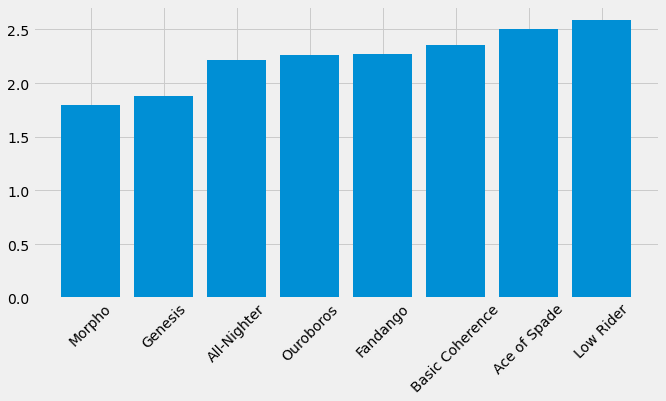

In [103]:
qual = tss_no_out.groupby('preset_label').mean(
)[["tss_qua_2", "tss_qua_1", "tss_qua_3"]].sort_values("tss_qua_2")

figure = plt.figure(figsize=(10, 5))
plt.bar(qual.index, qual["tss_qua_2"])
plt.xticks(rotation=45)

In [110]:
marg_means_df = params_df.loc[["Intercept", "Genesis", "Ouroboros", "Basic Coherence", "Low Rider"],
                              ["tss_coh", "tss_cre", "tss_avoid_rep", "tss_pac",
                               "tss_coh 90% CI margin", "tss_cre 90% CI margin",
                               "tss_avoid_rep 90% CI margin", "tss_pac 90% CI margin",
                               "tss_coh adj_p", "tss_cre adj_p",
                               "tss_avoid_rep adj_p", "tss_pac adj_p"]].copy()

for outcome in outcome_li:
    marg_means_df.loc[["Genesis", "Ouroboros", "Basic Coherence", "Low Rider"], outcome] = marg_means_df.loc[
        ["Genesis", "Ouroboros", "Basic Coherence", "Low Rider"], outcome].apply(
        lambda x: marg_means_df.loc["Intercept", outcome]+x)

marg_means_df.rename(index={"Intercept": "Grand Mean"}, inplace=True)
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_coh", "Coherence")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_cre", "Complexity / Creativity")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "tss_avoid_rep", "Avoiding Repitition")
marg_means_df.columns = marg_means_df.columns.str.replace("tss_pac", "Pace")

In [111]:
marg_means_df

,Coherence,Complexity / Creativity,Avoiding Repitition,Pace,Coherence 90% CI margin,Complexity / Creativity 90% CI margin,Avoiding Repitition 90% CI margin,Pace 90% CI margin,Coherence adj_p,Complexity / Creativity adj_p,Avoiding Repitition adj_p,Pace adj_p
Grand Mean,2.953417,2.670205,3.415339,3.270063,0.111708,0.106227,0.145103,0.122000,NaN,NaN,NaN,NaN
Genesis,2.655116,2.669123,3.640276,3.323432,0.174341,0.195403,0.216628,0.201243,0.039097,0.992737,0.350584,0.728945
Ouroboros,2.904552,2.688899,3.557155,3.214574,0.192698,0.195544,0.257469,0.226325,0.902132,0.992737,0.577429,0.728945
Basic Coherence,3.004405,2.706898,3.553532,3.360344,0.192049,0.203393,0.250134,0.230563,0.902132,0.992737,0.577429,0.728945
Low Rider,3.063298,2.749893,3.572077,3.204234,0.224576,0.191883,0.269608,0.312466,0.902132,0.989086,0.577429,0.728945


In [112]:
# Update GSheet from Basileus
gc = gs.oauth()

gsheet = gc.open("Preset Analysis").worksheet("Data")
gsheet_df = gd.get_as_dataframe(gsheet, index_col="Preset")
gsheet_df.update(marg_means_df)
gd.set_with_dataframe(gsheet, gsheet_df, include_index=True)

In [179]:
mask = ((tss_no_out["prompt_label"] == "Horror") &
        (tss_no_out["tss_coh"] > 2.37) &
        (tss_no_out["tss_coh"] < 2.63) &
        (tss_no_out["tss_avoid_rep"] < 3.15) &
        (tss_no_out["sample"] == "Community")
        )

tss_no_out[mask]

,response_id,story_id,prompt_label,preset_label,sample,tss_coh_1,tss_coh_2,tss_coh_3,tss_coh_4,tss_coh_5,...,words_cent,words_cent**2,words_cent**3,qual_2_agree+,qual_1_agree+,word_count_cent,tss_coh_cent,tss_cre_cent,tss_avoid_rep_cent,tss_pac_cent
39,R_3NJwJ1YI321mrzT,MOR_HOR_7,Horror,Morpho,Community,4.0,2.0,5.0,1.0,4.0,...,158.973913,25272.705028,4.017701e+06,0,0,159.545852,-0.308588,-0.432314,-1.425764,1.141194
101,R_DIYEG1Q8OTBQrUB,ACE_HOR_4,Horror,Ace of Spade,Community,4.0,2.0,4.0,3.0,3.0,...,-413.026087,170590.548507,-7.045835e+07,0,0,-412.454148,-0.419699,-1.182314,-0.175764,-0.525473
132,R_2Vxu9C5ghrThqx1,OUR_HOR_4,Horror,Ouroboros,Community,5.0,5.0,4.0,1.0,2.0,...,124.973913,15618.478941,1.951902e+06,0,0,125.545852,-0.308588,-0.682314,-0.925764,0.141194


In [180]:
print(tss_no_out.loc[132, "full_story"])

I woke up to hear knocking on glass. At first, I thought it was the window until I heard it come from the mirror again. I got out of bed and walked over to the mirror. When I looked into it, there was a face looking back at me. It was thin, long-nosed, and had sunken cheeks that almost disappeared under its gray skin. Its lips were pulled back in a wide smile and it held one hand out toward me as if beckoning me closer. As the other hand slowly traced its fingers down my cheek, I backed away, scared by what I saw reflected in the glass.
As I turned and ran for the door, the mirror began to shatter into thousands of tiny shards. I fell down on the floor and felt them slide under my skin like hundreds of tiny needles. In just seconds, they traveled down my body with all their little sharp ends reaching through the surface of my skin to the inner depths. I closed my eyes tight as the pain started to build, but as soon as the pain hit my mind, the glass began to move under my skin again. T

In [181]:
print(tss_no_out.loc[101, "full_story"])

I woke up to hear knocking on glass. At first, I thought it was the window until I heard it come from the mirror again. I got out of bed and walked over to the mirror. When I looked into it, there was a face looking back at me. It had a large nose that looked like an elephant's trunk with two large nostrils. The mouth was small and thin. Its eyes were small, but they seemed to be staring straight through me. There was a long black hair covering its head. This wasn't just any old man. It was a demon! I screamed and ran downstairs. My parents came running as well, and my dad called 911. We all stayed together in our living room waiting for the police. They said someone would be here shortly.
It was only ten minutes later when the doorbell rang. I opened it to see the sheriff standing outside. He asked if he could come inside. As soon as he stepped foot inside, he fell to his knees and began screaming. He then grabbed my father by the shirt and started shaking him violently. All this time